In [1]:
import numpy as np
import pandas as pd

# Hyperparameter tuning results

In [2]:
def shuffle_and_sample(x, txt_path):
    shuffled = x.sample(frac = 1, random_state = 0) # Shuffle the data with a fixed random state
    # We repeat the eval on the test set 5 times, but 9 times on the validation set
    top_n = 5 if 'test' in txt_path else 9
    return shuffled.head(top_n)
def remove_underscore_after(val): # Remove underscore, and keep the part after the underscore
    return val.split('_')[-1]
def remove_underscore_before(val): # Remove underscore, and keep the part before the underscore
    return val.split('_')[0]
def map2d(func, grid): # Mapping for 2d arrays, from: https://stackoverflow.com/questions/70742445/elegant-map-over-2d-list
    return [[func(value) for value in row] for row in grid]
def full_display(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df)
def prep_and_store_results(txt_path: str): # Prepare the (text-file) results to be stored in a csv
    with open(txt_path, 'r') as f:
        results = f.readlines()

    # Remove any non-result lines from the eval file, and split the lines on the tab character
    # (results have format: model_name\tdataset_name\tmetric_name\tmetric_value)
    results = [r.replace('\n','').split('\t') for r in results if '\t' in r]

    # Make a dataframe from the results
    df = pd.DataFrame(results, columns = ['model', 'dataset', 'metric', 'value'])
    df['value'] = pd.to_numeric(df['value'])
    # Remove the timestamp from the model names
    df['model'] = df['model'].map(lambda x: '-'.join(x.split('-')[2:]))

    # Make a list of model names, split by parameters - model names look like var1_xxx-var2_yyy-var3_zzz-... so split on '-'
    models = df['model'].str.split('-').tolist()
    
    # Remove all underscores from our 2d list, keep one list of the param names and one with param vals
    model_names_list = map2d(remove_underscore_before, models) # Keep the part before the underscore, aka the variable name
    model_names = np.array(model_names_list)
    model_val_list = map2d(remove_underscore_after, models) # Keep the part after the underscore, aka the variable's value
    model_vals = np.array(model_val_list)
    
    print('Number of evaluations:', model_vals.shape[0])

    # Splitting model name into columns, using the list of variables and their values
    for i in range(model_names.shape[-1]):
        name = model_names[0][i]
        val = model_vals[:,i]
        df[name] = val
        try: # Try to make columns numeric if possible
            df[name] = pd.to_numeric(df[name]) 
        except:
            pass
    
    # Remove columns that aren't used
    df = df.drop(['vit', 'model', 'data',   'kw'], axis = 1) #'method', 'AL.iter', 'ratio', 'PL', 'ALL',
    if 'fold' in df.columns.tolist():
        df = df.drop(['fold'], axis = 1)
    
    # Replace 'None' with NaN, to allow conversion to numerical
    df['AL.iter'] = df['AL.iter'].replace('None', np.nan)
    df['AL.iter'] = pd.to_numeric(df['AL.iter'])
    df['AL.epochs'] = df['AL.epochs'].replace('None', np.nan)
    df['AL.epochs'] = pd.to_numeric(df['AL.epochs'])

    cols = sorted(df.columns.tolist()) # Get a list of the columns of the dataframe
    print('Column names:', cols)

    display(df)

    # Group by the model parameters 
    df_grouped = df.groupby(list(set(cols)-set(['value'])), dropna = False)#.sample(frac=1).head(5 if 'test' in txt_path else 9)
    display(df_grouped.head(5 if 'test' in txt_path else 9))
    # Compute mean, std, max, min performance and number of runs for each model 
    df_grouped = df_grouped.agg({ # randomly pick X model runs to use in the analysis (5 for test, 9 for val) 
        'value': [('mean', lambda x: shuffle_and_sample(x, txt_path).mean()), 
                    ('std', lambda x: shuffle_and_sample(x, txt_path).std()), 
                    ('count', lambda x: shuffle_and_sample(x, txt_path).shape[0]),
                    ('all', lambda x: list(shuffle_and_sample(x, txt_path))), # keep a list of all the runs
                    ('min', lambda x: shuffle_and_sample(x, txt_path).min()),
                    ('max', lambda x: shuffle_and_sample(x, txt_path).max()),     
                 ]
    }) 

    df_grouped.to_csv(txt_path.replace('.txt', '.csv'))
    display(df_grouped)
    return df_grouped

def get_results_per_model(df, hyperparam_tuning = True):
    if hyperparam_tuning: # Only report on the results for a specific label ratio if we're hyperparam tuning
        df = df[(df['ratio'] == 0.1)]
#     df_no_finetune = df[(df['epochs']==0)]
    df_baseline = df[((df['AL.iter'].isna()) & (df['method'] == 'base') & (df['epochs'] > 0)) | (df['ratio'] == 0 )]
    df_S_CLIP = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('ot.'))]
    df_soft_PL = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('soft.'))]
    df_hard_PL = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('hard.'))]
    df_basic_AL = df[(df['AL.iter']>=0) & (df['ProbVLM']=='False') & (df['AL.epochs']<=20)]
    df_probvlm_AL = df[(df['ProbVLM']=='True')]
    
    return { # return a dictionary of results per model
        'baseline': df_baseline, 's-clip': df_S_CLIP,  #'baseline-not-finetuned' : df_no_finetune, 
        'soft-pl': df_soft_PL, 'hard-pl': df_hard_PL, 'basic-al': df_basic_AL, 'probvlm': df_probvlm_AL 
    }
    

In [3]:
validation_path = './results/eval.txt'
df_grouped = prep_and_store_results(validation_path)

Number of evaluations: 53410
Column names: ['AL.epochs', 'AL.iter', 'PL', 'ProbVLM', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,60.99,0.1,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,56.84,0.1,base,False,NaN,NaN,None,5,0.00005,64
2,RSICD,image_to_text_R@1,4.76,0.1,base,False,NaN,NaN,None,5,0.00005,64
3,RSICD,image_to_text_R@5,20.05,0.1,base,False,NaN,NaN,None,5,0.00005,64
4,RSICD,image_to_text_R@10,33.88,0.1,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
53405,Sydney,image_to_text_R@5,13.68,0.1,base,True,20.0,20.0,None,25,0.00005,32
53406,Sydney,image_to_text_R@10,19.52,0.1,base,True,20.0,20.0,None,25,0.00005,32
53407,Sydney,text_to_image_R@1,5.03,0.1,base,True,20.0,20.0,None,25,0.00005,32
53408,Sydney,text_to_image_R@5,12.47,0.1,base,True,20.0,20.0,None,25,0.00005,32


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,60.99,0.1,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,56.84,0.1,base,False,NaN,NaN,None,5,0.00005,64
2,RSICD,image_to_text_R@1,4.76,0.1,base,False,NaN,NaN,None,5,0.00005,64
3,RSICD,image_to_text_R@5,20.05,0.1,base,False,NaN,NaN,None,5,0.00005,64
4,RSICD,image_to_text_R@10,33.88,0.1,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
53405,Sydney,image_to_text_R@5,13.68,0.1,base,True,20.0,20.0,None,25,0.00005,32
53406,Sydney,image_to_text_R@10,19.52,0.1,base,True,20.0,20.0,None,25,0.00005,32
53407,Sydney,text_to_image_R@1,5.03,0.1,base,True,20.0,20.0,None,25,0.00005,32
53408,Sydney,text_to_image_R@5,12.47,0.1,base,True,20.0,20.0,None,25,0.00005,32


value  \
                                                                                                     mean   
AL.epochs bs  epochs ProbVLM lr      metric            method AL.iter dataset ratio PL                      
5.0       32  5      True    0.00005 image_to_text_R@1 base   5.0     RSICD   0.1   None         3.756667   
                                                                      Sydney  0.1   None         2.483333   
                                                                      UCM     0.1   None         7.120000   
                                                              10.0    RSICD   0.1   None         3.206667   
                                                                      Sydney  0.1   None         2.616667   
...                                                                                                   ...   
NaN       128 35     False   0.00050 zeroshot-val-top1 ours   NaN     UCM-CLS 0.1   hard.text    4.808889   
                                                                                    ot.image     5.906667   
                                                                                    ot.text     19.002222   
                                                                                    soft.image  11.246667   
                                                                                    soft.text    4.808889   

                                                                                                          \
                                                                                                     std   
AL.epochs bs  epochs ProbVLM lr      metric            method AL.iter dataset ratio PL                     
5.0       32  5      True    0.00005 image_to_text_R@1 base   5.0     RSICD   0.1   None        0.641431   
                                                                      Sydney  0.1   None        0.421940   
                                                                      UCM     0.1   None        0.987269   
                                                              10.0    RSICD   0.1   None        0.330051   
                                                                      Sydney  0.1   None        0.352184   
...                                                                                                  ...   
NaN       128 35     False   0.00050 zeroshot-val-top1 ours   NaN     UCM-CLS 0.1   hard.text   0.281800   
                                                                                    ot.image    2.690938   
                                                                                    ot.text     1.723940   
                                                                                    soft.image  4.526925   
                                                                                    soft.text   0.187979   

                                                                                                      \
                                                                                               count   
AL.epochs bs  epochs ProbVLM lr      metric            method AL.iter dataset ratio PL                 
5.0       32  5      True    0.00005 image_to_text_R@1 base   5.0     RSICD   0.1   None           3   
                                                                      Sydney  0.1   None           3   
                                                                      UCM     0.1   None           3   
                                                              10.0    RSICD   0.1   None           3   
                                                                      Sydney  0.1   None           3   
...                                                                                              ...   
NaN       128 35     False   0.00050 zeroshot-val-top1 ours   NaN     UCM-CLS 0.1   hard.text      9   
                    

In [4]:
df_results = df_grouped.reset_index()
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

AL.epochs   bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                                
2268       5.0   64      5   False  0.00050  image_to_text_R@1   ours     NaN   
4548      30.0   64     30   False  0.00050  image_to_text_R@1   ours     NaN   
2265       5.0   64      5   False  0.00050  image_to_text_R@1   ours     NaN   
7904      35.0  128     35   False  0.00050  image_to_text_R@1   ours     NaN   
4125      25.0   64     25   False  0.00050  image_to_text_R@1   ours     NaN   
...        ...  ...    ...     ...      ...                ...    ...     ...   
2246       5.0   64      5   False  0.00005  zeroshot-val-top1   base     NaN   
3247      15.0   64     15   False  0.00005  zeroshot-val-top1   base     NaN   
2247       5.0   64      5   False  0.00005  zeroshot-val-top1   base     NaN   
3246      15.0   64     15   False  0.00005  zeroshot-val-top1   base     NaN   
2747      10.0   64     10   False  0.00005  zeroshot-val-top1   base     NaN   

      dataset ratio         PL    value                  \
                                   mean       std count   
2268    RSICD   0.1  soft.text   0.0675  0.045000     4   
4548    RSICD   0.1  soft.text   0.0675  0.045000     4   
2265    RSICD   0.1   ot.image   0.0700  0.060000     9   
7904    RSICD   0.1  hard.text   0.0700  0.039686     9   
4125    RSICD   0.1   ot.image   0.0800  0.030000     9   
...       ...   ...        ...      ...       ...   ...   
2246  UCM-CLS   0.5       None  77.7550  3.436680     4   
3247  UCM-CLS   0.7       None  77.9725  3.209884     4   
2247  UCM-CLS   0.7       None  78.1875  5.256433     4   
3246  UCM-CLS   0.5       None  78.2875  3.939225     4   
2747  UCM-CLS   0.7       None  78.3975  3.115032     4   

                                                                       
                                                    all    min    max  
2268                            [0.09, 0.09, 0.09, 0.0]   0.00   0.09  
4548                            [0.09, 0.0, 0.09, 0.09]   0.00   0.09  
2265  [0.09, 0.0, 0.09, 0.09, 0.18, 0.09, 0.0, 0.0, ...   0.00   0.18  
7904  [0.09, 0.0, 0.09, 0.09, 0.09, 0.09, 0.0, 0.09,...   0.00   0.09  
4125  [0.09, 0.09, 0.09, 0.09, 0.09, 0.0, 0.09, 0.09...   0.00   0.09  
...                                                 ...    ...    ...  
2246                        [81.2, 77.68, 79.06, 73.08]  73.08  81.20  
3247                        [76.07, 82.4, 75.21, 78.21]  75.21  82.40  
2247                       [78.21, 83.26, 70.94, 80.34]  70.94  83.26  
3246                        [84.19, 76.39, 76.5, 76.07]  76.07  84.19  
2747                       [73.93, 80.26, 78.63, 80.77]  73.93  80.77  

[8040 rows x 17 columns]

In [5]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_model(df_results)
df_baseline = results_dict['baseline']
df_basic_AL = results_dict['basic-al']
df_probvlm_AL = results_dict['probvlm']
df_S_CLIP = results_dict['s-clip']
df_soft_PL = results_dict['soft-pl']
df_hard_PL = results_dict['hard-pl']

In [6]:
full_display(df_probvlm_AL.groupby(['metric', 'dataset']).tail(3))

AL.epochs  bs epochs ProbVLM       lr              metric method AL.iter  \
                                                                                
186        5.0  32     25    True  0.00005   image_to_text_R@1   base    20.0   
1092      20.0  32     10    True  0.00005   image_to_text_R@1   base     5.0   
620       10.0  32     25    True  0.00005   image_to_text_R@1   base     5.0   
561       10.0  32     15    True  0.00005   image_to_text_R@1   base     5.0   
184        5.0  32     25    True  0.00005   image_to_text_R@1   base    10.0   
1219      20.0  32     25    True  0.00005   image_to_text_R@1   base    20.0   
1220      20.0  32     25    True  0.00005   image_to_text_R@1   base    20.0   
622       10.0  32     25    True  0.00005   image_to_text_R@1   base     5.0   
1214      20.0  32     25    True  0.00005   image_to_text_R@1   base     5.0   
569       10.0  32     15    True  0.00005  image_to_text_R@10   base     5.0   
129        5.0  32     15    True  0.00005  image_to_text_R@10   base     5.0   
629       10.0  32     25    True  0.00005  image_to_text_R@10   base     5.0   
1165      20.0  32     15    True  0.00005  image_to_text_R@10   base    10.0   
1222      20.0  32     25    True  0.00005  image_to_text_R@10   base     5.0   
1228      20.0  32     25    True  0.00005  image_to_text_R@10   base    20.0   
634       10.0  32     25    True  0.00005  image_to_text_R@10   base    10.0   
74         5.0  32     10    True  0.00005  image_to_text_R@10   base    10.0   
71         5.0  32     10    True  0.00005  image_to_text_R@10   base     5.0   
201        5.0  32     25    True  0.00005   image_to_text_R@5   base    10.0   
144        5.0  32     15    True  0.00005   image_to_text_R@5   base    20.0   
638       10.0  32     25    True  0.00005   image_to_text_R@5   base     5.0   
1234      20.0  32     25    True  0.00005   image_to_text_R@5   base    10.0   
1237      20.0  32     25    True  0.00005   image_to_text_R@5   base    20.0   
1231      20.0  32     25    True  0.00005   image_to_text_R@5   base     5.0   
1238      20.0  32     25    True  0.00005   image_to_text_R@5   base    20.0   
643       10.0  32     25    True  0.00005   image_to_text_R@5   base    10.0   
1232      20.0  32     25    True  0.00005   image_to_text_R@5   base     5.0   
593       10.0  32     15    True  0.00005   text_to_image_R@1   base    20.0   
147        5.0  32     15    True  0.00005   text_to_image_R@1   base     5.0   
647       10.0  32     25    True  0.00005   text_to_image_R@1   base     5.0   
651       10.0  32     25    True  0.00005   text_to_image_R@1   base    10.0   
1246      20.0  32     25    True  0.00005   text_to_image_R@1   base    20.0   
1240      20.0  32     25    True  0.00005   text_to_image_R@1   base     5.0   
1181      20.0  32     15    True  0.00005   text_to_image_R@1   base     5.0   
212        5.0  32     25    True  0.00005   text_to_image_R@1   base    10.0   
209        5.0  32     25    True  0.00005   text_to_image_R@1   base     5.0   
1248      20.0  32     25    True  0.00005  text_to_image_R@10   base     5.0   
96         5.0  32     10    True  0.00005  text_to_image_R@10   base     5.0   
656       10.0  32     25    True  0.00005  text_to_image_R@10   base     5.0   
657       10.0  32     25    True  0.00005  text_to_image_R@10   base     5.0   
1255      20.0  32     25    True  0.00005  text_to_image_R@10   base    20.0   
1249      20.0  32     25    True  0.00005  text_to_image_R@10   base     5.0   
218        5.0  32     25    True  0.00005  text_to_image_R@10   base     5.0   
661       10.0  32     25    True  0.00005  text_to_image_R@10   base    10.0   
1250      20.0  32     25    True  0.00005  text_to_image_R@10   base     5.0   
231        5.0  32     25    True  0.00005   text_to_image_R@5   base    20.0   
611       10.0  32     15    True  0.00005   text_to_image_R@5   base    20.0   
665       10.0  32     25    True  0

In [7]:
# Results with basic active learning
full_display(df_basic_AL.groupby(['metric', 'dataset']).tail(3)) 

AL.epochs  bs epochs ProbVLM       lr              metric method AL.iter  \
                                                                                
383        5.0  64     20   False  0.00005   image_to_text_R@1   base    10.0   
912       10.0  64     20   False  0.00005   image_to_text_R@1   base     5.0   
915       10.0  64     20   False  0.00005   image_to_text_R@1   base    10.0   
1487      20.0  64     20   False  0.00005   image_to_text_R@1   base     5.0   
1570      20.0  64     25   False  0.00005   image_to_text_R@1   base    30.0   
1493      20.0  64     20   False  0.00005   image_to_text_R@1   base    20.0   
1491      20.0  64     20   False  0.00005   image_to_text_R@1   base    10.0   
385        5.0  64     20   False  0.00005   image_to_text_R@1   base    10.0   
1488      20.0  64     20   False  0.00005   image_to_text_R@1   base     5.0   
709       10.0  64     10   False  0.00005  image_to_text_R@10   base     5.0   
392        5.0  64     20   False  0.00005  image_to_text_R@10   base    10.0   
924       10.0  64     20   False  0.00005  image_to_text_R@10   base     5.0   
925       10.0  64     20   False  0.00005  image_to_text_R@10   base     5.0   
1576      20.0  64     25   False  0.00005  image_to_text_R@10   base    30.0   
1505      20.0  64     20   False  0.00005  image_to_text_R@10   base    20.0   
717       10.0  64     10   False  0.00005  image_to_text_R@10   base    20.0   
1372      20.0  64     15   False  0.00005  image_to_text_R@10   base    20.0   
394        5.0  64     20   False  0.00005  image_to_text_R@10   base    10.0   
1510      20.0  64     20   False  0.00005   image_to_text_R@5   base     5.0   
939       10.0  64     20   False  0.00005   image_to_text_R@5   base    10.0   
936       10.0  64     20   False  0.00005   image_to_text_R@5   base     5.0   
1520      20.0  64     20   False  0.00005   image_to_text_R@5   base    30.0   
1582      20.0  64     25   False  0.00005   image_to_text_R@5   base    30.0   
1517      20.0  64     20   False  0.00005   image_to_text_R@5   base    20.0   
726       10.0  64     10   False  0.00005   image_to_text_R@5   base    20.0   
1384      20.0  64     15   False  0.00005   image_to_text_R@5   base    20.0   
403        5.0  64     20   False  0.00005   image_to_text_R@5   base    10.0   
1010      10.0  64     25   False  0.00005   text_to_image_R@1   base    20.0   
1587      20.0  64     25   False  0.00005   text_to_image_R@1   base    30.0   
1531      20.0  64     20   False  0.00005   text_to_image_R@1   base    30.0   
949       10.0  64     20   False  0.00005   text_to_image_R@1   base     5.0   
1529      20.0  64     20   False  0.00005   text_to_image_R@1   base    20.0   
1588      20.0  64     25   False  0.00005   text_to_image_R@1   base    30.0   
1533      20.0  64     20   False  0.00005   text_to_image_R@1   base    30.0   
1527      20.0  64     20   False  0.00005   text_to_image_R@1   base    10.0   
1589      20.0  64     25   False  0.00005   text_to_image_R@1   base    30.0   
963       10.0  64     20   False  0.00005  text_to_image_R@10   base    10.0   
419        5.0  64     20   False  0.00005  text_to_image_R@10   base    10.0   
960       10.0  64     20   False  0.00005  text_to_image_R@10   base     5.0   
1020      10.0  64     25   False  0.00005  text_to_image_R@10   base    30.0   
1538      20.0  64     20   False  0.00005  text_to_image_R@10   base    10.0   
1541      20.0  64     20   False  0.00005  text_to_image_R@10   base    20.0   
1595      20.0  64     25   False  0.00005  text_to_image_R@10   base    30.0   
819       10.0  64     15   False  0.00005  text_to_image_R@10   base    30.0   
1408      20.0  64     15   False  0.00005  text_to_image_R@10   base    20.0   
428        5.0  64     20   False  0.00005   text_to_image_R@5   base    10.0   
1412      20.0  64     15   False  0.00005   text_to_image_R@5   base     5.0   
972       10.0  64     20   False  0

In [8]:
full_display(df_baseline.groupby(['metric', 'dataset']).tail(3))

AL.epochs   bs epochs ProbVLM       lr              metric method  \
                                                                         
3980      25.0   64     25   False  0.00005   image_to_text_R@1   base   
4820      35.0   64     35   False  0.00005   image_to_text_R@1   base   
4400      30.0   64     30   False  0.00005   image_to_text_R@1   base   
4401      30.0   64     30   False  0.00005   image_to_text_R@1   base   
7341      30.0  128     30   False  0.00005   image_to_text_R@1   base   
7761      35.0  128     35   False  0.00005   image_to_text_R@1   base   
4822      35.0   64     35   False  0.00005   image_to_text_R@1   base   
6922      25.0  128     25   False  0.00005   image_to_text_R@1   base   
4402      30.0   64     30   False  0.00005   image_to_text_R@1   base   
4421      30.0   64     30   False  0.00005  image_to_text_R@10   base   
4001      25.0   64     25   False  0.00005  image_to_text_R@10   base   
4841      35.0   64     35   False  0.00005  image_to_text_R@10   base   
7362      30.0  128     30   False  0.00005  image_to_text_R@10   base   
4422      30.0   64     30   False  0.00005  image_to_text_R@10   base   
4842      35.0   64     35   False  0.00005  image_to_text_R@10   base   
4843      35.0   64     35   False  0.00005  image_to_text_R@10   base   
7783      35.0  128     35   False  0.00005  image_to_text_R@10   base   
7363      30.0  128     30   False  0.00005  image_to_text_R@10   base   
4022      25.0   64     25   False  0.00005   image_to_text_R@5   base   
4442      30.0   64     30   False  0.00005   image_to_text_R@5   base   
4862      35.0   64     35   False  0.00005   image_to_text_R@5   base   
4443      30.0   64     30   False  0.00005   image_to_text_R@5   base   
7383      30.0  128     30   False  0.00005   image_to_text_R@5   base   
7803      35.0  128     35   False  0.00005   image_to_text_R@5   base   
7804      35.0  128     35   False  0.00005   image_to_text_R@5   base   
4864      35.0   64     35   False  0.00005   image_to_text_R@5   base   
7384      30.0  128     30   False  0.00005   image_to_text_R@5   base   
4043      25.0   64     25   False  0.00005   text_to_image_R@1   base   
4463      30.0   64     30   False  0.00005   text_to_image_R@1   base   
4883      35.0   64     35   False  0.00005   text_to_image_R@1   base   
6984      25.0  128     25   False  0.00005   text_to_image_R@1   base   
7404      30.0  128     30   False  0.00005   text_to_image_R@1   base   
7824      35.0  128     35   False  0.00005   text_to_image_R@1   base   
4465      30.0   64     30   False  0.00005   text_to_image_R@1   base   
7405      30.0  128     30   False  0.00005   text_to_image_R@1   base   
7825      35.0  128     35   False  0.00005   text_to_image_R@1   base   
4064      25.0   64     25   False  0.00005  text_to_image_R@10   base   
4904      35.0   64     35   False  0.00005  text_to_image_R@10   base   
4484      30.0   64     30   False  0.00005  text_to_image_R@10   base   
7845      35.0  128     35   False  0.00005  text_to_image_R@10   base   
4905      35.0   64     35   False  0.00005  text_to_image_R@10   base   
4485      30.0   64     30   False  0.00005  text_to_image_R@10   base   
7846      35.0  128     35   False  0.00005  text_to_image_R@10   base   
4486      30.0   64     30   False  0.00005  text_to_image_R@10   base   
4906      35.0   64     35   False  0.00005  text_to_image_R@10   base   
4085      25.0   64     25   False  0.00005   text_to_image_R@5   base   
4925      35.0   64     35   False  0.00005   text_to_image_R@5   base   
4505      30.0   64     30   False  0.00005   text_to_image_R@5   base   
7446      30.0  128     30   False  0.00005   text_to_image_R@5   base   
4926      35.0   64     35   False  0.00005   text_to_image_R@5   base   
7866      35.0  128     35   False  0.00005   text_to_image_R@5   base   
4927      35.0   64     35   False  0.00005   text_to_image_R@5   base   
4507     

In [9]:
full_display(df_S_CLIP.groupby(['metric', 'dataset']).tail(3))

AL.epochs   bs epochs ProbVLM       lr              metric method  \
                                                                         
6925      25.0  128     25   False  0.00005   image_to_text_R@1   ours   
7345      30.0  128     30   False  0.00005   image_to_text_R@1   ours   
7765      35.0  128     35   False  0.00005   image_to_text_R@1   ours   
6091      15.0  128     15   False  0.00005   image_to_text_R@1   ours   
7351      30.0  128     30   False  0.00005   image_to_text_R@1   ours   
7771      35.0  128     35   False  0.00005   image_to_text_R@1   ours   
6937      25.0  128     25   False  0.00005   image_to_text_R@1   ours   
7357      30.0  128     30   False  0.00005   image_to_text_R@1   ours   
7777      35.0  128     35   False  0.00005   image_to_text_R@1   ours   
6946      25.0  128     25   False  0.00005  image_to_text_R@10   ours   
7786      35.0  128     35   False  0.00005  image_to_text_R@10   ours   
7366      30.0  128     30   False  0.00005  image_to_text_R@10   ours   
6952      25.0  128     25   False  0.00005  image_to_text_R@10   ours   
7372      30.0  128     30   False  0.00005  image_to_text_R@10   ours   
7792      35.0  128     35   False  0.00005  image_to_text_R@10   ours   
4858      35.0   64     35   False  0.00005  image_to_text_R@10   ours   
7378      30.0  128     30   False  0.00005  image_to_text_R@10   ours   
7798      35.0  128     35   False  0.00005  image_to_text_R@10   ours   
6967      25.0  128     25   False  0.00005   image_to_text_R@5   ours   
7387      30.0  128     30   False  0.00005   image_to_text_R@5   ours   
7807      35.0  128     35   False  0.00005   image_to_text_R@5   ours   
4453      30.0   64     30   False  0.00005   image_to_text_R@5   ours   
7393      30.0  128     30   False  0.00005   image_to_text_R@5   ours   
7813      35.0  128     35   False  0.00005   image_to_text_R@5   ours   
7819      35.0  128     35   False  0.00005   image_to_text_R@5   ours   
7399      30.0  128     30   False  0.00005   image_to_text_R@5   ours   
6979      25.0  128     25   False  0.00005   image_to_text_R@5   ours   
7408      30.0  128     30   False  0.00005   text_to_image_R@1   ours   
7828      35.0  128     35   False  0.00005   text_to_image_R@1   ours   
4888      35.0   64     35   False  0.00005   text_to_image_R@1   ours   
7834      35.0  128     35   False  0.00005   text_to_image_R@1   ours   
7414      30.0  128     30   False  0.00005   text_to_image_R@1   ours   
6994      25.0  128     25   False  0.00005   text_to_image_R@1   ours   
7000      25.0  128     25   False  0.00005   text_to_image_R@1   ours   
7420      30.0  128     30   False  0.00005   text_to_image_R@1   ours   
7840      35.0  128     35   False  0.00005   text_to_image_R@1   ours   
7009      25.0  128     25   False  0.00005  text_to_image_R@10   ours   
7429      30.0  128     30   False  0.00005  text_to_image_R@10   ours   
7849      35.0  128     35   False  0.00005  text_to_image_R@10   ours   
7015      25.0  128     25   False  0.00005  text_to_image_R@10   ours   
7435      30.0  128     30   False  0.00005  text_to_image_R@10   ours   
7855      35.0  128     35   False  0.00005  text_to_image_R@10   ours   
7441      30.0  128     30   False  0.00005  text_to_image_R@10   ours   
4921      35.0   64     35   False  0.00005  text_to_image_R@10   ours   
7861      35.0  128     35   False  0.00005  text_to_image_R@10   ours   
7030      25.0  128     25   False  0.00005   text_to_image_R@5   ours   
7870      35.0  128     35   False  0.00005   text_to_image_R@5   ours   
7450      30.0  128     30   False  0.00005   text_to_image_R@5   ours   
7036      25.0  128     25   False  0.00005   text_to_image_R@5   ours   
7456      30.0  128     30   False  0.00005   text_to_image_R@5   ours   
7876      35.0  128     35   False  0.00005   text_to_image_R@5   ours   
7042      25.0  128     25   False  0.00005   text_to_image_R@5   ours   
7462     

In [10]:
full_display(df_soft_PL.groupby(['metric', 'dataset']).tail(3))

AL.epochs   bs epochs ProbVLM       lr              metric method  \
                                                                         
4408      30.0   64     30   False  0.00005   image_to_text_R@1   ours   
7347      30.0  128     30   False  0.00005   image_to_text_R@1   ours   
4828      35.0   64     35   False  0.00005   image_to_text_R@1   ours   
7353      30.0  128     30   False  0.00005   image_to_text_R@1   ours   
4834      35.0   64     35   False  0.00005   image_to_text_R@1   ours   
7773      35.0  128     35   False  0.00005   image_to_text_R@1   ours   
7360      30.0  128     30   False  0.00005   image_to_text_R@1   ours   
4840      35.0   64     35   False  0.00005   image_to_text_R@1   ours   
7780      35.0  128     35   False  0.00005   image_to_text_R@1   ours   
7789      35.0  128     35   False  0.00005  image_to_text_R@10   ours   
4849      35.0   64     35   False  0.00005  image_to_text_R@10   ours   
4429      30.0   64     30   False  0.00005  image_to_text_R@10   ours   
4015      25.0   64     25   False  0.00005  image_to_text_R@10   ours   
7375      30.0  128     30   False  0.00005  image_to_text_R@10   ours   
7795      35.0  128     35   False  0.00005  image_to_text_R@10   ours   
6960      25.0  128     25   False  0.00005  image_to_text_R@10   ours   
4861      35.0   64     35   False  0.00005  image_to_text_R@10   ours   
4441      30.0   64     30   False  0.00005  image_to_text_R@10   ours   
7810      35.0  128     35   False  0.00005   image_to_text_R@5   ours   
4450      30.0   64     30   False  0.00005   image_to_text_R@5   ours   
4870      35.0   64     35   False  0.00005   image_to_text_R@5   ours   
7815      35.0  128     35   False  0.00005   image_to_text_R@5   ours   
7396      30.0  128     30   False  0.00005   image_to_text_R@5   ours   
7816      35.0  128     35   False  0.00005   image_to_text_R@5   ours   
7402      30.0  128     30   False  0.00005   image_to_text_R@5   ours   
4462      30.0   64     30   False  0.00005   image_to_text_R@5   ours   
4882      35.0   64     35   False  0.00005   image_to_text_R@5   ours   
7831      35.0  128     35   False  0.00005   text_to_image_R@1   ours   
4471      30.0   64     30   False  0.00005   text_to_image_R@1   ours   
7411      30.0  128     30   False  0.00005   text_to_image_R@1   ours   
6997      25.0  128     25   False  0.00005   text_to_image_R@1   ours   
7416      30.0  128     30   False  0.00005   text_to_image_R@1   ours   
7837      35.0  128     35   False  0.00005   text_to_image_R@1   ours   
7002      25.0  128     25   False  0.00005   text_to_image_R@1   ours   
4903      35.0   64     35   False  0.00005   text_to_image_R@1   ours   
7842      35.0  128     35   False  0.00005   text_to_image_R@1   ours   
7852      35.0  128     35   False  0.00005  text_to_image_R@10   ours   
4492      30.0   64     30   False  0.00005  text_to_image_R@10   ours   
4912      35.0   64     35   False  0.00005  text_to_image_R@10   ours   
7438      30.0  128     30   False  0.00005  text_to_image_R@10   ours   
7857      35.0  128     35   False  0.00005  text_to_image_R@10   ours   
7858      35.0  128     35   False  0.00005  text_to_image_R@10   ours   
4084      25.0   64     25   False  0.00005  text_to_image_R@10   ours   
4504      30.0   64     30   False  0.00005  text_to_image_R@10   ours   
4924      35.0   64     35   False  0.00005  text_to_image_R@10   ours   
7453      30.0  128     30   False  0.00005   text_to_image_R@5   ours   
4513      30.0   64     30   False  0.00005   text_to_image_R@5   ours   
4933      35.0   64     35   False  0.00005   text_to_image_R@5   ours   
7459      30.0  128     30   False  0.00005   text_to_image_R@5   ours   
7458      30.0  128     30   False  0.00005   text_to_image_R@5   ours   
7878      35.0  128     35   False  0.00005   text_to_image_R@5   ours   
4945      35.0   64     35   False  0.00005   text_to_image_R@5   ours   
7885     

In [11]:
full_display(df_hard_PL.groupby(['metric', 'dataset']).tail(3))

AL.epochs   bs epochs ProbVLM       lr              metric method  \
                                                                         
3984      25.0   64     25   False  0.00005   image_to_text_R@1   ours   
7764      35.0  128     35   False  0.00005   image_to_text_R@1   ours   
4824      35.0   64     35   False  0.00005   image_to_text_R@1   ours   
4829      35.0   64     35   False  0.00005   image_to_text_R@1   ours   
4409      30.0   64     30   False  0.00005   image_to_text_R@1   ours   
3990      25.0   64     25   False  0.00005   image_to_text_R@1   ours   
4415      30.0   64     30   False  0.00005   image_to_text_R@1   ours   
7356      30.0  128     30   False  0.00005   image_to_text_R@1   ours   
7776      35.0  128     35   False  0.00005   image_to_text_R@1   ours   
7785      35.0  128     35   False  0.00005  image_to_text_R@10   ours   
4425      30.0   64     30   False  0.00005  image_to_text_R@10   ours   
4845      35.0   64     35   False  0.00005  image_to_text_R@10   ours   
7791      35.0  128     35   False  0.00005  image_to_text_R@10   ours   
4431      30.0   64     30   False  0.00005  image_to_text_R@10   ours   
4851      35.0   64     35   False  0.00005  image_to_text_R@10   ours   
4436      30.0   64     30   False  0.00005  image_to_text_R@10   ours   
4857      35.0   64     35   False  0.00005  image_to_text_R@10   ours   
4437      30.0   64     30   False  0.00005  image_to_text_R@10   ours   
4866      35.0   64     35   False  0.00005   image_to_text_R@5   ours   
4026      25.0   64     25   False  0.00005   image_to_text_R@5   ours   
4446      30.0   64     30   False  0.00005   image_to_text_R@5   ours   
4452      30.0   64     30   False  0.00005   image_to_text_R@5   ours   
7812      35.0  128     35   False  0.00005   image_to_text_R@5   ours   
4032      25.0   64     25   False  0.00005   image_to_text_R@5   ours   
7818      35.0  128     35   False  0.00005   image_to_text_R@5   ours   
4877      35.0   64     35   False  0.00005   image_to_text_R@5   ours   
7398      30.0  128     30   False  0.00005   image_to_text_R@5   ours   
4047      25.0   64     25   False  0.00005   text_to_image_R@1   ours   
4467      30.0   64     30   False  0.00005   text_to_image_R@1   ours   
4887      35.0   64     35   False  0.00005   text_to_image_R@1   ours   
6993      25.0  128     25   False  0.00005   text_to_image_R@1   ours   
7833      35.0  128     35   False  0.00005   text_to_image_R@1   ours   
7413      30.0  128     30   False  0.00005   text_to_image_R@1   ours   
4479      30.0   64     30   False  0.00005   text_to_image_R@1   ours   
7839      35.0  128     35   False  0.00005   text_to_image_R@1   ours   
4898      35.0   64     35   False  0.00005   text_to_image_R@1   ours   
7848      35.0  128     35   False  0.00005  text_to_image_R@10   ours   
4488      30.0   64     30   False  0.00005  text_to_image_R@10   ours   
4908      35.0   64     35   False  0.00005  text_to_image_R@10   ours   
4494      30.0   64     30   False  0.00005  text_to_image_R@10   ours   
7434      30.0  128     30   False  0.00005  text_to_image_R@10   ours   
7854      35.0  128     35   False  0.00005  text_to_image_R@10   ours   
4500      30.0   64     30   False  0.00005  text_to_image_R@10   ours   
4080      25.0   64     25   False  0.00005  text_to_image_R@10   ours   
4920      35.0   64     35   False  0.00005  text_to_image_R@10   ours   
7869      35.0  128     35   False  0.00005   text_to_image_R@5   ours   
4509      30.0   64     30   False  0.00005   text_to_image_R@5   ours   
4929      35.0   64     35   False  0.00005   text_to_image_R@5   ours   
4095      25.0   64     25   False  0.00005   text_to_image_R@5   ours   
7455      30.0  128     30   False  0.00005   text_to_image_R@5   ours   
7875      35.0  128     35   False  0.00005   text_to_image_R@5   ours   
7461      30.0  128     30   False  0.00005   text_to_image_R@5   ours   
4941     

# Test split evaluation results

In [12]:
test_path = './results/test_eval.txt'
df_grouped = prep_and_store_results(test_path)

Number of evaluations: 75352
Column names: ['AL.epochs', 'AL.iter', 'PL', 'ProbVLM', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,48.58,0.05,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,46.19,0.05,base,False,NaN,NaN,None,5,0.00005,64
2,WHU-RS19,zeroshot-val-top1,71.94,0.05,base,False,NaN,NaN,None,5,0.00005,64
3,RSSCN7,zeroshot-val-top1,58.14,0.05,base,False,NaN,NaN,None,5,0.00005,64
4,AID,zeroshot-val-top1,52.05,0.05,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
75347,Sydney,image_to_text_R@5,25.75,0.40,base,False,20.0,10.0,None,20,0.00005,64
75348,Sydney,image_to_text_R@10,33.80,0.40,base,False,20.0,10.0,None,20,0.00005,64
75349,Sydney,text_to_image_R@1,8.85,0.40,base,False,20.0,10.0,None,20,0.00005,64
75350,Sydney,text_to_image_R@5,26.56,0.40,base,False,20.0,10.0,None,20,0.00005,64


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,48.58,0.05,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,46.19,0.05,base,False,NaN,NaN,None,5,0.00005,64
2,WHU-RS19,zeroshot-val-top1,71.94,0.05,base,False,NaN,NaN,None,5,0.00005,64
3,RSSCN7,zeroshot-val-top1,58.14,0.05,base,False,NaN,NaN,None,5,0.00005,64
4,AID,zeroshot-val-top1,52.05,0.05,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
75347,Sydney,image_to_text_R@5,25.75,0.40,base,False,20.0,10.0,None,20,0.00005,64
75348,Sydney,image_to_text_R@10,33.80,0.40,base,False,20.0,10.0,None,20,0.00005,64
75349,Sydney,text_to_image_R@1,8.85,0.40,base,False,20.0,10.0,None,20,0.00005,64
75350,Sydney,text_to_image_R@5,26.56,0.40,base,False,20.0,10.0,None,20,0.00005,64


value  \
                                                                                                 mean   
AL.epochs bs  epochs ProbVLM lr      metric            method AL.iter dataset  ratio PL                 
10.0      32  25     True    0.00005 image_to_text_R@1 base   2.0     RSICD    0.05  None       2.360   
                                                                      Sydney   0.05  None       2.092   
                                                                      UCM      0.05  None       7.334   
                                                              5.0     RSICD    0.10  None       3.570   
                                                                      Sydney   0.10  None       3.420   
...                                                                                               ...   
NaN       128 25     False   0.00005 zeroshot-val-top1 ours   NaN     WHU-RS19 0.05  ot.image  76.776   
                                                                               0.10  ot.image  84.932   
                                                                               0.20  ot.image  87.784   
                                                                               0.40  ot.image  95.780   
                                                                               0.80  ot.image  96.678   

                                                                                                             \
                                                                                                        std   
AL.epochs bs  epochs ProbVLM lr      metric            method AL.iter dataset  ratio PL                       
10.0      32  25     True    0.00005 image_to_text_R@1 base   2.0     RSICD    0.05  None      4.472136e-01   
                                                                      Sydney   0.05  None      6.305712e-01   
                                                                      UCM      0.05  None      6.395154e-01   
                                                              5.0     RSICD    0.10  None      4.965068e-16   
                                                                      Sydney   0.10  None      4.965068e-16   
...                                                                                                     ...   
NaN       128 25     False   0.00005 zeroshot-val-top1 ours   NaN     WHU-RS19 0.05  ot.image  1.231109e+00   
                                                                               0.10  ot.image  9.793978e-01   
                                                                               0.20  ot.image  2.714587e+00   
                                                                               0.40  ot.image  1.341641e-01   
                                                                               0.80  ot.image  3.532987e-01   

                                                                                                     \
                                                                                              count   
AL.epochs bs  epochs ProbVLM lr      metric            method AL.iter dataset  ratio PL               
10.0      32  25     True    0.00005 image_to_text_R@1 base   2.0     RSICD    0.05  None         5   
                                                                      Sydney   0.05  None         5   
                                                                      UCM      0.05  None         5   
                                                              5.0     RSICD    0.10  None         5   
                                                                      Sydney   0.10  None         5   
...                                                                                             ...   
NaN       128 25     False   0.00005 zeroshot-val-top1 ours   NaN     WHU-RS19 0.05  ot.image     5   
                                        

In [13]:
df_results = df_grouped.reset_index()
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

AL.epochs   bs epochs ProbVLM       lr             metric method  \
                                                                         
252         1.0   64      1   False  0.00005  image_to_text_R@1   ours   
9293        1.0  128      1   False  0.00005  image_to_text_R@1   ours   
9292        1.0  128      1   False  0.00005  image_to_text_R@1   ours   
253         1.0   64      1   False  0.00005  image_to_text_R@1   ours   
9412        2.0  128      2   False  0.00005  image_to_text_R@1   ours   
...         ...  ...    ...     ...      ...                ...    ...   
7490       22.0   64     22   False  0.00005  zeroshot-val-top1   ours   
10851      13.0  128     13   False  0.00005  zeroshot-val-top1   ours   
7802       23.0   64     23   False  0.00005  zeroshot-val-top1   ours   
11691      20.0  128     20   False  0.00005  zeroshot-val-top1   ours   
11571      19.0  128     19   False  0.00005  zeroshot-val-top1   ours   

      AL.iter   dataset ratio         PL   value                  \
                                            mean       std count   
252       NaN     RSICD  0.05  hard.text   0.694  0.049295     5   
9293      NaN     RSICD  0.10   ot.image   0.912  0.067231     5   
9292      NaN     RSICD  0.05   ot.image   1.010  0.000000     5   
253       NaN     RSICD  0.05  soft.text   1.040  0.238747     5   
9412      NaN     RSICD  0.05   ot.image   1.300  0.318512     5   
...       ...       ...   ...        ...     ...       ...   ...   
7490      NaN  WHU-RS19  0.80  hard.text  97.172  0.979398     5   
10851     NaN  WHU-RS19  0.80   ot.image  97.272  0.308577     5   
7802      NaN  WHU-RS19  0.80  hard.text  97.352  1.024119     5   
11691     NaN  WHU-RS19  0.80   ot.image  97.372  0.308577     5   
11571     NaN  WHU-RS19  0.80   ot.image  97.532  0.621627     5   

                                                          
                                       all    min    max  
252         [0.73, 0.73, 0.64, 0.73, 0.64]   0.64   0.73  
9293        [0.91, 1.01, 0.82, 0.91, 0.91]   0.82   1.01  
9292        [1.01, 1.01, 1.01, 1.01, 1.01]   1.01   1.01  
253         [0.91, 1.46, 1.01, 0.91, 0.91]   0.91   1.46  
9412           [1.1, 1.83, 1.1, 1.1, 1.37]   1.10   1.83  
...                                    ...    ...    ...  
7490   [97.61, 95.42, 97.61, 97.61, 97.61]  95.42  97.61  
10851  [97.41, 96.72, 97.41, 97.41, 97.41]  96.72  97.41  
7802   [97.81, 95.52, 97.81, 97.81, 97.81]  95.52  97.81  
11691  [97.51, 96.82, 97.51, 97.51, 97.51]  96.82  97.51  
11571  [97.81, 96.42, 97.81, 97.81, 97.81]  96.42  97.81  

[12292 rows x 17 columns]

In [14]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_model(df_results, False)
# df_no_finetune = results_dict['baseline-not-finetuned']
df_baseline = results_dict['baseline']
df_basic_AL = results_dict['basic-al']
df_S_CLIP = results_dict['s-clip']
df_soft_PL = results_dict['soft-pl']
df_hard_PL = results_dict['hard-pl']

In [15]:
df_baseline = df_baseline[(df_baseline['epochs']==25)&(df_baseline['bs']==64)&(df_baseline['lr']==5e-5)]
full_display(df_baseline) # .groupby(['metric', 'dataset'])

AL.epochs  bs epochs ProbVLM       lr              metric method AL.iter  \
                                                                                
8116      25.0  64     25   False  0.00005   image_to_text_R@1   base     NaN   
8117      25.0  64     25   False  0.00005   image_to_text_R@1   base     NaN   
8118      25.0  64     25   False  0.00005   image_to_text_R@1   base     NaN   
8119      25.0  64     25   False  0.00005   image_to_text_R@1   base     NaN   
8121      25.0  64     25   False  0.00005   image_to_text_R@1   base     NaN   
8120      25.0  64     25   False  0.00005   image_to_text_R@1   base     NaN   
8122      25.0  64     25   False  0.00005   image_to_text_R@1   base     NaN   
8123      25.0  64     25   False  0.00005   image_to_text_R@1   base     NaN   
8124      25.0  64     25   False  0.00005   image_to_text_R@1   base     NaN   
8125      25.0  64     25   False  0.00005   image_to_text_R@1   base     NaN   
8126      25.0  64     25   False  0.00005   image_to_text_R@1   base     NaN   
8127      25.0  64     25   False  0.00005   image_to_text_R@1   base     NaN   
8128      25.0  64     25   False  0.00005   image_to_text_R@1   base     NaN   
8129      25.0  64     25   False  0.00005   image_to_text_R@1   base     NaN   
8130      25.0  64     25   False  0.00005   image_to_text_R@1   base     NaN   
8131      25.0  64     25   False  0.00005   image_to_text_R@1   base     NaN   
8132      25.0  64     25   False  0.00005   image_to_text_R@1   base     NaN   
8133      25.0  64     25   False  0.00005   image_to_text_R@1   base     NaN   
8164      25.0  64     25   False  0.00005  image_to_text_R@10   base     NaN   
8165      25.0  64     25   False  0.00005  image_to_text_R@10   base     NaN   
8166      25.0  64     25   False  0.00005  image_to_text_R@10   base     NaN   
8167      25.0  64     25   False  0.00005  image_to_text_R@10   base     NaN   
8168      25.0  64     25   False  0.00005  image_to_text_R@10   base     NaN   
8169      25.0  64     25   False  0.00005  image_to_text_R@10   base     NaN   
8170      25.0  64     25   False  0.00005  image_to_text_R@10   base     NaN   
8171      25.0  64     25   False  0.00005  image_to_text_R@10   base     NaN   
8172      25.0  64     25   False  0.00005  image_to_text_R@10   base     NaN   
8173      25.0  64     25   False  0.00005  image_to_text_R@10   base     NaN   
8174      25.0  64     25   False  0.00005  image_to_text_R@10   base     NaN   
8175      25.0  64     25   False  0.00005  image_to_text_R@10   base     NaN   
8176      25.0  64     25   False  0.00005  image_to_text_R@10   base     NaN   
8177      25.0  64     25   False  0.00005  image_to_text_R@10   base     NaN   
8178      25.0  64     25   False  0.00005  image_to_text_R@10   base     NaN   
8179      25.0  64     25   False  0.00005  image_to_text_R@10   base     NaN   
8180      25.0  64     25   False  0.00005  image_to_text_R@10   base     NaN   
8181      25.0  64     25   False  0.00005  image_to_text_R@10   base     NaN   
8212      25.0  64     25   False  0.00005   image_to_text_R@5   base     NaN   
8213      25.0  64     25   False  0.00005   image_to_text_R@5   base     NaN   
8214      25.0  64     25   False  0.00005   image_to_text_R@5   base     NaN   
8215      25.0  64     25   False  0.00005   image_to_text_R@5   base     NaN   
8216      25.0  64     25   False  0.00005   image_to_text_R@5   base     NaN   
8217      25.0  64     25   False  0.00005   image_to_text_R@5   base     NaN   
8218      25.0  64     25   False  0.00005   image_to_text_R@5   base     NaN   
8219      25.0  64     25   False  0.00005   image_to_text_R@5   base     NaN   
8220      25.0  64     25   False  0.00005   image_to_text_R@5   base     NaN   
8221      25.0  64     25   False  0.00005   image_to_text_R@5   base     NaN   
8223      25.0  64     25   False  0.00005   image_to_text_R@5   base     NaN   
8222      25.0  64     25   False  0

In [17]:
def performance_per_label_ratio(df, metric, dataset):
    df_filtered = df[(df['metric'] == metric) & (df['dataset'] == dataset)]
    # Ensure the order is from the smallest label ratio to the largest
    df_filtered = df_filtered.sort_values(by='ratio')
    display(df_filtered)
    # Get the mean, std, min, max performance on the given metric & dataset
    mean = df_filtered[('value', 'mean')].to_numpy()
    std = df_filtered[('value', 'std')].to_numpy()
    min_ = df_filtered[('value', 'min')].to_numpy()
    max_ = df_filtered[('value', 'max')].to_numpy()
#     label_ratios = df_filtered['ratio'].tolist()
    return {'mean': mean, 'std': std, 'min': min_, 'max': max_}

In [20]:
import matplotlib.pyplot as plt
def plot_model_comparison(results_dict, metric, dataset, which_models = 'all'):
    only_scores = {}
    models = results_dict.keys()
    
    # Filter for specific types of models
    if which_models == 'pseudo-labeling':
        models = ['baseline', 's-clip', 'soft-pl', 'hard-pl'] 
    if which_models == 'active-learning':
        models = ['baseline', 'basic-al']  # 'probvlm'
        
    # Which epochs to filter to, for each model
    epochs = {'baseline': [0, 25], 'basic-al': [20], 'probvlm': [25], 's-clip': [25], 'soft-pl': [30], 
              'hard-pl': [25],  } # 'probvlm': ..., 'baseline-not-finetuned': [0]
    
    # The label ratios that we use
    label_ratios = [0.0, 0.05, 0.1, 0.2, 0.4, 0.8, 1.0] 
    
    # Get list of colors (used to make the plot of the mean and the std around it have the same color)
    cmap = plt.cm.get_cmap("tab10")
    color_list = cmap.colors
    
    # Add information about the dataset, metric and label ratios to the plot
    fig = plt.figure(figsize=(12, 6)) # resize figure
    metric_formatted = metric.replace('_', ' ')
    plt.title(f'{metric_formatted} (dataset: {dataset})')
    plt.xticks(label_ratios, label_ratios)
    ylabel = 'recall' if 'R@' in metric else 'accuracy'
    plt.ylabel(ylabel)
    plt.xlabel('Label ratio')
    
    
    # Get the performance of each model, for the given metric and dataset
    for i, model in enumerate(models):
        model_results = results_dict[model]
        # If we have any results for the given model, add it to the plot
        if model_results is not None and model_results.shape[0] > 0: 
            # Filter for correct number of epochs
            model_results = model_results[model_results['epochs'].isin(epochs[model])]
            print(model, metric, dataset)
            performance = performance_per_label_ratio(model_results, metric, dataset)
            mean = performance['mean']
            # Pad the performance if it misses results at label_ratio = 0 (start) and label_ratio = 1 (end)
            pad_start = 1 if len(mean) != len(label_ratios) else 0
            # compute how much to pad at end - this is equal to 1 if all results are known
            pad_end = len(label_ratios) - len(mean) - pad_start 
#                 print('pad end:', pad_end)
            mean = np.pad(mean, (pad_start, pad_end), 'constant', constant_values=np.nan)
            max_ = np.pad(performance['max'], (pad_start, pad_end), 'constant', constant_values=np.nan)
            min_ = np.pad(performance['min'], (pad_start, pad_end), 'constant', constant_values=np.nan)
#                 std = np.pad(performance['std'], (pad_start, pad_end), 'constant', constant_values=np.nan) # Do the same for the std

            plt.plot(label_ratios, mean, label = model, linestyle = '-', color = color_list[i])

            # Add the minimum and maximum performance as a 'band' of confidence around the mean
            plt.fill_between(label_ratios, min_, max_, alpha=0.2, color = color_list[i])
            model_results_all_scores = model_results[('value', 'all')].tolist()
            only_scores[model] = model_results_all_scores
    plt.legend()
    plt.show()
    return only_scores

baseline image_to_text_R@5 RSICD


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                               
222        0.0  64      0   False  0.00005  image_to_text_R@5   base     NaN   
8212      25.0  64     25   False  0.00005  image_to_text_R@5   base     NaN   
8213      25.0  64     25   False  0.00005  image_to_text_R@5   base     NaN   
8214      25.0  64     25   False  0.00005  image_to_text_R@5   base     NaN   
8215      25.0  64     25   False  0.00005  image_to_text_R@5   base     NaN   
8216      25.0  64     25   False  0.00005  image_to_text_R@5   base     NaN   
8217      25.0  64     25   False  0.00005  image_to_text_R@5   base     NaN   

     dataset ratio    PL   value                  \
                            mean       std count   
222    RSICD  0.00  None  12.530  0.000000     2   
8212   RSICD  0.05  None  12.992  0.965023     5   
8213   RSICD  0.10  None  17.108  0.715730     5   
8214   RSICD  0.20  None  21.264  0.627120     5   
8215   RSICD  0.40  None  25.308  0.668296     5   
8216   RSICD  0.80  None  28.928  0.533170     5   
8217   RSICD  1.00  None  30.450  1.038821     5   

                                                         
                                      all    min    max  
222                        [12.53, 12.53]  12.53  12.53  
8212  [14.27, 13.36, 12.99, 12.72, 11.62]  11.62  14.27  
8213   [16.1, 17.57, 16.65, 17.84, 17.38]  16.10  17.84  
8214  [20.59, 20.77, 22.14, 21.59, 21.23]  20.59  22.14  
8215  [24.43, 25.25, 26.26, 25.07, 25.53]  24.43  26.26  
8216   [29.0, 29.64, 29.09, 28.73, 28.18]  28.18  29.64  
8217  [28.91, 30.47, 31.84, 30.47, 30.56]  28.91  31.84

s-clip image_to_text_R@5 RSICD


AL.epochs   bs epochs ProbVLM       lr             metric method  \
                                                                         
12202      25.0  128     25   False  0.00005  image_to_text_R@5   ours   
12203      25.0  128     25   False  0.00005  image_to_text_R@5   ours   
12204      25.0  128     25   False  0.00005  image_to_text_R@5   ours   
12205      25.0  128     25   False  0.00005  image_to_text_R@5   ours   
12206      25.0  128     25   False  0.00005  image_to_text_R@5   ours   

      AL.iter dataset ratio        PL   value                  \
                                         mean       std count   
12202     NaN   RSICD  0.05  ot.image  14.054  0.175442     5   
12203     NaN   RSICD  0.10  ot.image  17.288  0.406964     5   
12204     NaN   RSICD  0.20  ot.image  20.422  0.652932     5   
12205     NaN   RSICD  0.40  ot.image  24.502  0.160997     5   
12206     NaN   RSICD  0.80  ot.image  28.890  0.355246     5   

                                                          
                                       all    min    max  
12202  [14.18, 14.18, 14.18, 13.91, 13.82]  13.82  14.18  
12203  [17.47, 16.56, 17.47, 17.47, 17.47]  16.56  17.47  
12204  [20.13, 21.59, 20.13, 20.13, 20.13]  20.13  21.59  
12205  [24.43, 24.79, 24.43, 24.43, 24.43]  24.43  24.79  
12206  [29.09, 28.27, 29.09, 29.09, 28.91]  28.27  29.09

soft-pl image_to_text_R@5 RSICD


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                               
9046      30.0  64     30   False  0.00005  image_to_text_R@5   ours     NaN   
9047      30.0  64     30   False  0.00005  image_to_text_R@5   ours     NaN   
9048      30.0  64     30   False  0.00005  image_to_text_R@5   ours     NaN   
9049      30.0  64     30   False  0.00005  image_to_text_R@5   ours     NaN   
9050      30.0  64     30   False  0.00005  image_to_text_R@5   ours     NaN   

     dataset ratio         PL   value                  \
                                 mean       std count   
9046   RSICD  0.05  soft.text  14.548  1.289484     5   
9047   RSICD  0.10  soft.text  17.456  0.516169     5   
9048   RSICD  0.20  soft.text  21.864  1.338462     5   
9049   RSICD  0.40  soft.text  23.918  0.636137     5   
9050   RSICD  0.80  soft.text  28.966  0.631847     5   

                                                         
                                      all    min    max  
9046    [15.74, 12.9, 15.1, 15.55, 13.45]  12.90  15.74  
9047  [17.11, 17.11, 18.02, 18.02, 17.02]  17.02  18.02  
9048  [22.87, 20.31, 20.49, 22.87, 22.78]  20.31  22.87  
9049  [24.25, 24.61, 23.24, 23.24, 24.25]  23.24  24.61  
9050  [28.45, 29.28, 29.92, 28.73, 28.45]  28.45  29.92

hard-pl image_to_text_R@5 RSICD


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                               
8230      25.0  64     25   False  0.00005  image_to_text_R@5   ours     NaN   
8232      25.0  64     25   False  0.00005  image_to_text_R@5   ours     NaN   
8234      25.0  64     25   False  0.00005  image_to_text_R@5   ours     NaN   
8236      25.0  64     25   False  0.00005  image_to_text_R@5   ours     NaN   
8238      25.0  64     25   False  0.00005  image_to_text_R@5   ours     NaN   

     dataset ratio         PL   value                  \
                                 mean       std count   
8230   RSICD  0.05  hard.text  13.706  1.082603     5   
8232   RSICD  0.10  hard.text  17.310  0.658141     5   
8234   RSICD  0.20  hard.text  20.018  0.399274     5   
8236   RSICD  0.40  hard.text  25.546  1.126202     5   
8238   RSICD  0.80  hard.text  29.712  0.040249     5   

                                                         
                                      all    min    max  
8230   [13.27, 12.9, 14.91, 12.63, 14.82]  12.63  14.91  
8232  [16.65, 18.02, 16.93, 18.02, 16.93]  16.65  18.02  
8234    [19.85, 20.4, 19.4, 20.22, 20.22]  19.40  20.40  
8236   [26.08, 26.35, 25.25, 23.7, 26.35]  23.70  26.35  
8238  [29.73, 29.64, 29.73, 29.73, 29.73]  29.64  29.73

basic-al image_to_text_R@5 RSICD


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                              
144      10.0  64     20   False  0.00005  image_to_text_R@5   base     2.0   
147      10.0  64     20   False  0.00005  image_to_text_R@5   base     5.0   
150      10.0  64     20   False  0.00005  image_to_text_R@5   base    10.0   
153      10.0  64     20   False  0.00005  image_to_text_R@5   base    20.0   

    dataset ratio    PL   value                  \
                           mean       std count   
144   RSICD  0.05  None  12.296  0.346309     5   
147   RSICD  0.10  None  14.218  0.438885     5   
150   RSICD  0.20  None  18.900  0.301247     5   
153   RSICD  0.40  None  22.050  0.000000     5   

                                                        
                                     all    min    max  
144  [12.44, 11.99, 12.72, 11.89, 12.44]  11.89  12.72  
147      [14.0, 14.09, 14.0, 15.0, 14.0]  14.00  15.00  
150  [19.12, 19.12, 18.57, 18.57, 19.12]  18.57  19.12  
153  [22.05, 22.05, 22.05, 22.05, 22.05]  22.05  22.05

probvlm image_to_text_R@5 RSICD


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                             
30      10.0  32     25    True  0.00005  image_to_text_R@5   base     2.0   
33      10.0  32     25    True  0.00005  image_to_text_R@5   base     5.0   
36      10.0  32     25    True  0.00005  image_to_text_R@5   base    10.0   
39      10.0  32     25    True  0.00005  image_to_text_R@5   base    20.0   
42      10.0  32     25    True  0.00005  image_to_text_R@5   base    40.0   

   dataset ratio    PL   value                  \
                          mean       std count   
30   RSICD  0.05  None   8.582  0.160997     5   
33   RSICD  0.10  None  15.262  0.098590     5   
36   RSICD  0.20  None  19.300  0.000000     5   
39   RSICD  0.40  None  21.302  1.731797     5   
42   RSICD  0.80  None  23.660  1.191994     5   

                                                       
                                    all    min    max  
30       [8.51, 8.87, 8.51, 8.51, 8.51]   8.51   8.87  
33  [15.19, 15.19, 15.19, 15.37, 15.37]  15.19  15.37  
36       [19.3, 19.3, 19.3, 19.3, 19.3]  19.30  19.30  
39  [22.42, 22.42, 22.42, 18.48, 20.77]  18.48  22.42  
42   [22.87, 24.52, 24.25, 21.96, 24.7]  21.96  24.70

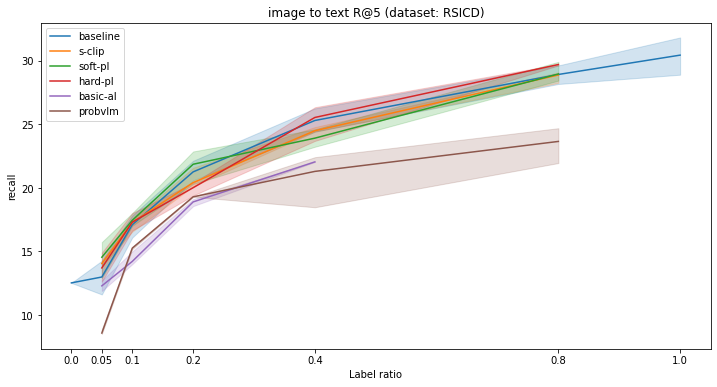

baseline image_to_text_R@5 UCM


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                               
224        0.0  64      0   False  0.00005  image_to_text_R@5   base     NaN   
8224      25.0  64     25   False  0.00005  image_to_text_R@5   base     NaN   
8225      25.0  64     25   False  0.00005  image_to_text_R@5   base     NaN   
8226      25.0  64     25   False  0.00005  image_to_text_R@5   base     NaN   
8227      25.0  64     25   False  0.00005  image_to_text_R@5   base     NaN   
8228      25.0  64     25   False  0.00005  image_to_text_R@5   base     NaN   
8229      25.0  64     25   False  0.00005  image_to_text_R@5   base     NaN   

     dataset ratio    PL   value                  \
                            mean       std count   
224      UCM  0.00  None  29.520  0.000000     2   
8224     UCM  0.05  None  34.954  1.704444     5   
8225     UCM  0.10  None  39.810  3.220877     5   
8226     UCM  0.20  None  48.286  2.395074     5   
8227     UCM  0.40  None  52.000  2.412955     5   
8228     UCM  0.80  None  55.716  1.784637     5   
8229     UCM  1.00  None  58.384  1.562380     5   

                                                         
                                      all    min    max  
224                        [29.52, 29.52]  29.52  29.52  
8224  [36.19, 35.24, 36.67, 32.38, 34.29]  32.38  36.67  
8225  [36.67, 39.52, 42.86, 43.33, 36.67]  36.67  43.33  
8226    [50.0, 44.76, 50.95, 47.62, 48.1]  44.76  50.95  
8227  [51.43, 50.48, 49.52, 55.71, 52.86]  49.52  55.71  
8228   [53.33, 55.24, 55.24, 58.1, 56.67]  53.33  58.10  
8229     [56.67, 58.1, 60.95, 58.1, 58.1]  56.67  60.95

s-clip image_to_text_R@5 UCM


AL.epochs   bs epochs ProbVLM       lr             metric method  \
                                                                         
12212      25.0  128     25   False  0.00005  image_to_text_R@5   ours   
12213      25.0  128     25   False  0.00005  image_to_text_R@5   ours   
12214      25.0  128     25   False  0.00005  image_to_text_R@5   ours   
12215      25.0  128     25   False  0.00005  image_to_text_R@5   ours   
12216      25.0  128     25   False  0.00005  image_to_text_R@5   ours   

      AL.iter dataset ratio        PL   value                  \
                                         mean       std count   
12212     NaN     UCM  0.05  ot.image  36.092  2.085454     5   
12213     NaN     UCM  0.10  ot.image  42.478  0.854178     5   
12214     NaN     UCM  0.20  ot.image  50.474  1.064368     5   
12215     NaN     UCM  0.40  ot.image  49.052  2.128737     5   
12216     NaN     UCM  0.80  ot.image  59.050  2.936614     5   

                                                          
                                       all    min    max  
12212  [35.71, 33.81, 35.71, 35.71, 39.52]  33.81  39.52  
12213  [42.86, 40.95, 42.86, 42.86, 42.86]  40.95  42.86  
12214  [50.95, 48.57, 50.95, 50.95, 50.95]  48.57  50.95  
12215      [48.1, 52.86, 48.1, 48.1, 48.1]  48.10  52.86  
12216   [60.48, 53.81, 60.48, 60.48, 60.0]  53.81  60.48

soft-pl image_to_text_R@5 UCM


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                               
9056      30.0  64     30   False  0.00005  image_to_text_R@5   ours     NaN   
9057      30.0  64     30   False  0.00005  image_to_text_R@5   ours     NaN   
9058      30.0  64     30   False  0.00005  image_to_text_R@5   ours     NaN   
9059      30.0  64     30   False  0.00005  image_to_text_R@5   ours     NaN   
9060      30.0  64     30   False  0.00005  image_to_text_R@5   ours     NaN   

     dataset ratio         PL   value                  \
                                 mean       std count   
9056     UCM  0.05  soft.text  37.334  1.737910     5   
9057     UCM  0.10  soft.text  40.286  3.309151     5   
9058     UCM  0.20  soft.text  47.240  2.743866     5   
9059     UCM  0.40  soft.text  52.952  3.537438     5   
9060     UCM  0.80  soft.text  55.428  1.043417     5   

                                                         
                                      all    min    max  
9056   [38.57, 35.71, 35.24, 38.1, 39.05]  35.24  39.05  
9057  [38.57, 46.19, 39.05, 39.05, 38.57]  38.57  46.19  
9058  [49.05, 42.86, 46.19, 49.05, 49.05]  42.86  49.05  
9059  [52.38, 47.62, 56.19, 56.19, 52.38]  47.62  56.19  
9060  [55.71, 55.24, 56.67, 53.81, 55.71]  53.81  56.67

hard-pl image_to_text_R@5 UCM


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                               
8250      25.0  64     25   False  0.00005  image_to_text_R@5   ours     NaN   
8252      25.0  64     25   False  0.00005  image_to_text_R@5   ours     NaN   
8254      25.0  64     25   False  0.00005  image_to_text_R@5   ours     NaN   
8256      25.0  64     25   False  0.00005  image_to_text_R@5   ours     NaN   
8258      25.0  64     25   False  0.00005  image_to_text_R@5   ours     NaN   

     dataset ratio         PL   value                  \
                                 mean       std count   
8250     UCM  0.05  hard.text  35.622  4.884902     5   
8252     UCM  0.10  hard.text  42.760  1.915568     5   
8254     UCM  0.20  hard.text  47.810  3.423543     5   
8256     UCM  0.40  hard.text  54.666  3.020576     5   
8258     UCM  0.80  hard.text  57.052  2.343399     5   

                                                         
                                      all    min    max  
8250  [34.29, 33.81, 32.86, 44.29, 32.86]  32.86  44.29  
8252    [40.48, 44.76, 41.9, 44.76, 41.9]  40.48  44.76  
8254    [50.0, 51.9, 48.57, 44.29, 44.29]  44.29  51.90  
8256  [54.76, 57.62, 50.95, 52.38, 57.62]  50.95  57.62  
8258      [58.1, 52.86, 58.1, 58.1, 58.1]  52.86  58.10

basic-al image_to_text_R@5 UCM


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                              
146      10.0  64     20   False  0.00005  image_to_text_R@5   base     2.0   
149      10.0  64     20   False  0.00005  image_to_text_R@5   base     5.0   
152      10.0  64     20   False  0.00005  image_to_text_R@5   base    10.0   
155      10.0  64     20   False  0.00005  image_to_text_R@5   base    20.0   

    dataset ratio    PL   value                  \
                           mean       std count   
146     UCM  0.05  None  34.192  0.780814     5   
149     UCM  0.10  None  41.426  1.614491     5   
152     UCM  0.20  None  46.476  2.349730     5   
155     UCM  0.40  None  50.956  2.607159     5   

                                                        
                                     all    min    max  
146  [34.29, 34.76, 32.86, 34.76, 34.29]  32.86  34.76  
149    [41.9, 41.9, 42.38, 38.57, 42.38]  38.57  42.38  
152  [44.76, 44.76, 49.05, 49.05, 44.76]  44.76  49.05  
155    [52.86, 52.86, 48.1, 48.1, 52.86]  48.10  52.86

probvlm image_to_text_R@5 UCM


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                             
32      10.0  32     25    True  0.00005  image_to_text_R@5   base     2.0   
35      10.0  32     25    True  0.00005  image_to_text_R@5   base     5.0   
38      10.0  32     25    True  0.00005  image_to_text_R@5   base    10.0   
41      10.0  32     25    True  0.00005  image_to_text_R@5   base    20.0   
44      10.0  32     25    True  0.00005  image_to_text_R@5   base    40.0   

   dataset ratio    PL   value                  \
                          mean       std count   
32     UCM  0.05  None  29.812  1.493693     5   
35     UCM  0.10  None  37.140  0.000000     5   
38     UCM  0.20  None  48.570  0.000000     5   
41     UCM  0.40  None  49.140  4.208943     5   
44     UCM  0.80  None  50.096  5.414188     5   

                                                       
                                    all    min    max  
32  [30.48, 27.14, 30.48, 30.48, 30.48]  27.14  30.48  
35  [37.14, 37.14, 37.14, 37.14, 37.14]  37.14  37.14  
38  [48.57, 48.57, 48.57, 48.57, 48.57]  48.57  48.57  
41     [51.9, 51.9, 51.9, 42.38, 47.62]  42.38  51.90  
44  [54.29, 44.76, 43.81, 55.24, 52.38]  43.81  55.24

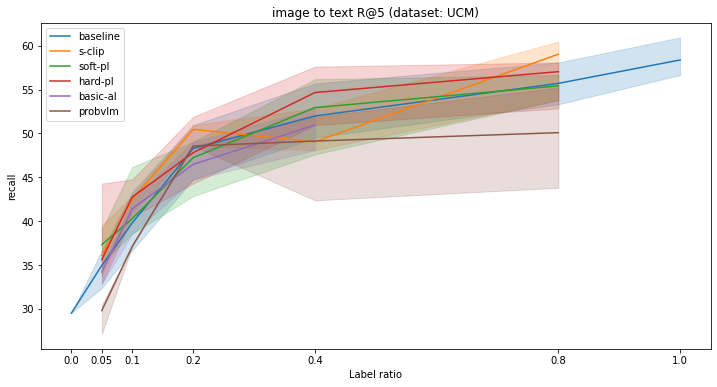

baseline image_to_text_R@5 Sydney


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                               
223        0.0  64      0   False  0.00005  image_to_text_R@5   base     NaN   
8218      25.0  64     25   False  0.00005  image_to_text_R@5   base     NaN   
8219      25.0  64     25   False  0.00005  image_to_text_R@5   base     NaN   
8220      25.0  64     25   False  0.00005  image_to_text_R@5   base     NaN   
8221      25.0  64     25   False  0.00005  image_to_text_R@5   base     NaN   
8222      25.0  64     25   False  0.00005  image_to_text_R@5   base     NaN   
8223      25.0  64     25   False  0.00005  image_to_text_R@5   base     NaN   

     dataset ratio    PL   value                  \
                            mean       std count   
223   Sydney  0.00  None   7.040  0.000000     2   
8218  Sydney  0.05  None   9.498  1.629193     5   
8219  Sydney  0.10  None  10.944  1.842099     5   
8220  Sydney  0.20  None  15.454  1.396954     5   
8221  Sydney  0.40  None  25.954  1.208338     5   
8222  Sydney  0.80  None  39.274  1.375384     5   
8223  Sydney  1.00  None  38.270  1.289981     5   

                                                         
                                      all    min    max  
223                          [7.04, 7.04]   7.04   7.04  
8218      [7.85, 9.26, 8.45, 9.86, 12.07]   7.85  12.07  
8219    [9.86, 11.87, 9.05, 13.68, 10.26]   9.05  13.68  
8220     [14.69, 17.1, 13.48, 15.9, 16.1]  13.48  17.10  
8221  [27.36, 25.55, 26.56, 26.16, 24.14]  24.14  27.36  
8222  [39.64, 40.64, 37.22, 40.24, 38.63]  37.22  40.64  
8223  [40.44, 37.63, 38.43, 37.63, 37.22]  37.22  40.44

s-clip image_to_text_R@5 Sydney


AL.epochs   bs epochs ProbVLM       lr             metric method  \
                                                                         
12207      25.0  128     25   False  0.00005  image_to_text_R@5   ours   
12208      25.0  128     25   False  0.00005  image_to_text_R@5   ours   
12209      25.0  128     25   False  0.00005  image_to_text_R@5   ours   
12210      25.0  128     25   False  0.00005  image_to_text_R@5   ours   
12211      25.0  128     25   False  0.00005  image_to_text_R@5   ours   

      AL.iter dataset ratio        PL   value                  \
                                         mean       std count   
12207     NaN  Sydney  0.05  ot.image   9.940  0.862583     5   
12208     NaN  Sydney  0.10  ot.image  11.748  0.720014     5   
12209     NaN  Sydney  0.20  ot.image  13.120  0.089443     5   
12210     NaN  Sydney  0.40  ot.image  19.152  0.093915     5   
12211     NaN  Sydney  0.80  ot.image  31.268  1.657564     5   

                                                          
                                       all    min    max  
12207      [9.86, 11.27, 9.86, 9.86, 8.85]   8.85  11.27  
12208  [12.07, 10.46, 12.07, 12.07, 12.07]  10.46  12.07  
12209  [13.08, 13.28, 13.08, 13.08, 13.08]  13.08  13.28  
12210  [19.11, 19.32, 19.11, 19.11, 19.11]  19.11  19.32  
12211   [31.79, 28.37, 31.79, 31.79, 32.6]  28.37  32.60

soft-pl image_to_text_R@5 Sydney


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                               
9051      30.0  64     30   False  0.00005  image_to_text_R@5   ours     NaN   
9052      30.0  64     30   False  0.00005  image_to_text_R@5   ours     NaN   
9053      30.0  64     30   False  0.00005  image_to_text_R@5   ours     NaN   
9054      30.0  64     30   False  0.00005  image_to_text_R@5   ours     NaN   
9055      30.0  64     30   False  0.00005  image_to_text_R@5   ours     NaN   

     dataset ratio         PL   value                  \
                                 mean       std count   
9051  Sydney  0.05  soft.text   9.294  0.846540     5   
9052  Sydney  0.10  soft.text  10.786  1.423808     5   
9053  Sydney  0.20  soft.text  14.526  0.929774     5   
9054  Sydney  0.40  soft.text  19.920  1.479223     5   
9055  Sydney  0.80  soft.text  27.928  1.676595     5   

                                                         
                                      all    min    max  
9051     [10.06, 8.25, 8.85, 10.26, 9.05]   8.25  10.26  
9052    [11.67, 12.27, 9.26, 9.26, 11.47]   9.26  12.27  
9053   [13.88, 15.09, 15.9, 13.88, 13.88]  13.88  15.90  
9054  [18.31, 20.72, 21.13, 21.13, 18.31]  18.31  21.13  
9055  [29.38, 28.17, 25.35, 27.36, 29.38]  25.35  29.38

hard-pl image_to_text_R@5 Sydney


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                               
8240      25.0  64     25   False  0.00005  image_to_text_R@5   ours     NaN   
8242      25.0  64     25   False  0.00005  image_to_text_R@5   ours     NaN   
8244      25.0  64     25   False  0.00005  image_to_text_R@5   ours     NaN   
8246      25.0  64     25   False  0.00005  image_to_text_R@5   ours     NaN   
8248      25.0  64     25   False  0.00005  image_to_text_R@5   ours     NaN   

     dataset ratio         PL   value                  \
                                 mean       std count   
8240  Sydney  0.05  hard.text   9.900  0.822830     5   
8242  Sydney  0.10  hard.text  11.548  1.408020     5   
8244  Sydney  0.20  hard.text  12.234  1.341801     5   
8246  Sydney  0.40  hard.text  18.390  1.413895     5   
8248  Sydney  0.80  hard.text  24.706  1.712828     5   

                                                         
                                      all    min    max  
8240     [9.66, 9.26, 10.66, 9.05, 10.87]   9.05  10.87  
8242  [10.26, 10.66, 13.08, 10.66, 13.08]  10.26  13.08  
8244  [12.47, 13.88, 13.08, 10.87, 10.87]  10.87  13.88  
8246    [19.32, 17.1, 20.32, 18.11, 17.1]  17.10  20.32  
8248  [23.94, 27.77, 23.94, 23.94, 23.94]  23.94  27.77

basic-al image_to_text_R@5 Sydney


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                              
145      10.0  64     20   False  0.00005  image_to_text_R@5   base     2.0   
148      10.0  64     20   False  0.00005  image_to_text_R@5   base     5.0   
151      10.0  64     20   False  0.00005  image_to_text_R@5   base    10.0   
154      10.0  64     20   False  0.00005  image_to_text_R@5   base    20.0   

    dataset ratio    PL   value                  \
                           mean       std count   
145  Sydney  0.05  None   9.658  0.603341     5   
148  Sydney  0.10  None  11.588  0.747409     5   
151  Sydney  0.20  None  13.804  0.991378     5   
154  Sydney  0.40  None  24.142  2.201845     5   

                                                        
                                     all    min    max  
145     [9.46, 10.26, 8.85, 10.26, 9.46]   8.85  10.26  
148  [11.87, 11.87, 12.07, 10.26, 11.87]  10.26  12.07  
151  [13.08, 13.08, 14.89, 14.89, 13.08]  13.08  14.89  
154  [25.75, 25.75, 21.73, 21.73, 25.75]  21.73  25.75

probvlm image_to_text_R@5 Sydney


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                             
31      10.0  32     25    True  0.00005  image_to_text_R@5   base     2.0   
34      10.0  32     25    True  0.00005  image_to_text_R@5   base     5.0   
37      10.0  32     25    True  0.00005  image_to_text_R@5   base    10.0   
40      10.0  32     25    True  0.00005  image_to_text_R@5   base    20.0   
43      10.0  32     25    True  0.00005  image_to_text_R@5   base    40.0   

   dataset ratio    PL   value                  \
                          mean       std count   
31  Sydney  0.05  None   8.772  0.720014     5   
34  Sydney  0.10  None   8.450  0.000000     5   
37  Sydney  0.20  None  13.480  0.000000     5   
40  Sydney  0.40  None  15.088  0.791846     5   
43  Sydney  0.80  None  19.636  2.547240     5   

                                                       
                                    all    min    max  
31      [8.45, 10.06, 8.45, 8.45, 8.45]   8.45  10.06  
34       [8.45, 8.45, 8.45, 8.45, 8.45]   8.45   8.45  
37  [13.48, 13.48, 13.48, 13.48, 13.48]  13.48  13.48  
40  [15.49, 15.49, 15.49, 13.68, 15.29]  13.68  15.49  
43   [19.11, 18.51, 16.9, 19.92, 23.74]  16.90  23.74

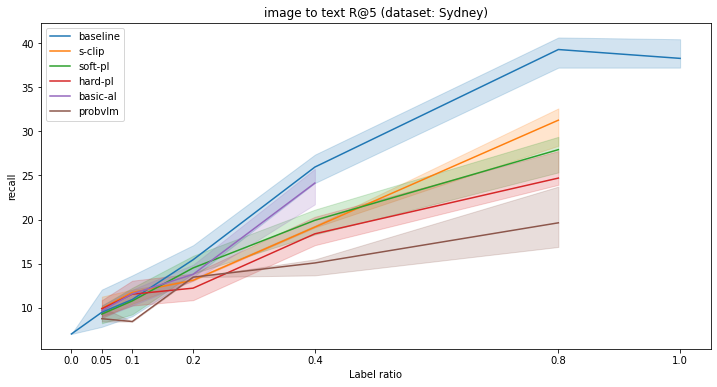

baseline text_to_image_R@5 RSICD


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                               
231        0.0  64      0   False  0.00005  text_to_image_R@5   base     NaN   
8356      25.0  64     25   False  0.00005  text_to_image_R@5   base     NaN   
8357      25.0  64     25   False  0.00005  text_to_image_R@5   base     NaN   
8358      25.0  64     25   False  0.00005  text_to_image_R@5   base     NaN   
8359      25.0  64     25   False  0.00005  text_to_image_R@5   base     NaN   
8360      25.0  64     25   False  0.00005  text_to_image_R@5   base     NaN   
8361      25.0  64     25   False  0.00005  text_to_image_R@5   base     NaN   

     dataset ratio    PL   value                  \
                            mean       std count   
231    RSICD  0.00  None  14.270  0.000000     2   
8356   RSICD  0.05  None  13.122  0.420678     5   
8357   RSICD  0.10  None  16.690  0.939920     5   
8358   RSICD  0.20  None  20.806  1.018052     5   
8359   RSICD  0.40  None  24.904  0.638968     5   
8360   RSICD  0.80  None  29.532  0.979525     5   
8361   RSICD  1.00  None  31.070  1.026913     5   

                                                         
                                      all    min    max  
231                        [14.27, 14.27]  14.27  14.27  
8356  [13.27, 13.54, 12.72, 12.63, 13.45]  12.63  13.54  
8357  [15.65, 18.12, 16.47, 16.19, 17.02]  15.65  18.12  
8358  [20.31, 19.67, 22.42, 20.77, 20.86]  19.67  22.42  
8359  [24.15, 24.61, 25.89, 24.89, 24.98]  24.15  25.89  
8360  [28.45, 30.92, 28.82, 29.46, 30.01]  28.45  30.92  
8361  [30.19, 30.74, 32.85, 30.74, 30.83]  30.19  32.85

s-clip text_to_image_R@5 RSICD


AL.epochs   bs epochs ProbVLM       lr             metric method  \
                                                                         
12247      25.0  128     25   False  0.00005  text_to_image_R@5   ours   
12248      25.0  128     25   False  0.00005  text_to_image_R@5   ours   
12249      25.0  128     25   False  0.00005  text_to_image_R@5   ours   
12250      25.0  128     25   False  0.00005  text_to_image_R@5   ours   
12251      25.0  128     25   False  0.00005  text_to_image_R@5   ours   

      AL.iter dataset ratio        PL   value                  \
                                         mean       std count   
12247     NaN   RSICD  0.05  ot.image  13.924  0.474847     5   
12248     NaN   RSICD  0.10  ot.image  17.196  0.818401     5   
12249     NaN   RSICD  0.20  ot.image  19.978  0.286217     5   
12250     NaN   RSICD  0.40  ot.image  23.462  0.898899     5   
12251     NaN   RSICD  0.80  ot.image  28.968  0.733430     5   

                                                          
                                       all    min    max  
12247  [14.27, 13.45, 14.27, 14.27, 13.36]  13.36  14.27  
12248  [16.83, 18.66, 16.83, 16.83, 16.83]  16.83  18.66  
12249  [19.85, 20.49, 19.85, 19.85, 19.85]  19.85  20.49  
12250  [23.06, 25.07, 23.06, 23.06, 23.06]  23.06  25.07  
12251  [28.64, 30.28, 28.64, 28.64, 28.64]  28.64  30.28

soft-pl text_to_image_R@5 RSICD


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                               
9127      30.0  64     30   False  0.00005  text_to_image_R@5   ours     NaN   
9128      30.0  64     30   False  0.00005  text_to_image_R@5   ours     NaN   
9129      30.0  64     30   False  0.00005  text_to_image_R@5   ours     NaN   
9130      30.0  64     30   False  0.00005  text_to_image_R@5   ours     NaN   
9131      30.0  64     30   False  0.00005  text_to_image_R@5   ours     NaN   

     dataset ratio         PL   value                  \
                                 mean       std count   
9127   RSICD  0.05  soft.text  14.638  0.614549     5   
9128   RSICD  0.10  soft.text  18.152  0.697653     5   
9129   RSICD  0.20  soft.text  22.234  1.206764     5   
9130   RSICD  0.40  soft.text  25.712  0.497112     5   
9131   RSICD  0.80  soft.text  30.062  1.053551     5   

                                                         
                                      all    min    max  
9127  [14.73, 13.63, 14.91, 14.64, 15.28]  13.63  15.28  
9128   [17.84, 19.4, 17.84, 17.84, 17.84]  17.84  19.40  
9129   [23.06, 21.59, 20.4, 23.06, 23.06]  20.40  23.06  
9130  [26.26, 24.98, 25.62, 25.62, 26.08]  24.98  26.26  
9131  [28.91, 30.83, 30.74, 30.92, 28.91]  28.91  30.92

hard-pl text_to_image_R@5 RSICD


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                               
8374      25.0  64     25   False  0.00005  text_to_image_R@5   ours     NaN   
8376      25.0  64     25   False  0.00005  text_to_image_R@5   ours     NaN   
8378      25.0  64     25   False  0.00005  text_to_image_R@5   ours     NaN   
8380      25.0  64     25   False  0.00005  text_to_image_R@5   ours     NaN   
8382      25.0  64     25   False  0.00005  text_to_image_R@5   ours     NaN   

     dataset ratio         PL   value                  \
                                 mean       std count   
8374   RSICD  0.05  hard.text  13.630  0.606795     5   
8376   RSICD  0.10  hard.text  17.988  1.053812     5   
8378   RSICD  0.20  hard.text  20.258  0.612021     5   
8380   RSICD  0.40  hard.text  25.616  0.849723     5   
8382   RSICD  0.80  hard.text  30.248  0.532184     5   

                                                         
                                      all    min    max  
8374  [12.99, 13.45, 14.27, 13.17, 14.27]  12.99  14.27  
8376  [16.38, 17.84, 18.94, 17.84, 18.94]  16.38  18.94  
8378  [19.21, 20.68, 20.22, 20.59, 20.59]  19.21  20.68  
8380   [24.79, 26.44, 25.71, 24.7, 26.44]  24.70  26.44  
8382   [30.01, 31.2, 30.01, 30.01, 30.01]  30.01  31.20

basic-al text_to_image_R@5 RSICD


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                              
180      10.0  64     20   False  0.00005  text_to_image_R@5   base     2.0   
183      10.0  64     20   False  0.00005  text_to_image_R@5   base     5.0   
186      10.0  64     20   False  0.00005  text_to_image_R@5   base    10.0   
189      10.0  64     20   False  0.00005  text_to_image_R@5   base    20.0   

    dataset ratio    PL   value                  \
                           mean       std count   
180   RSICD  0.05  None  11.786  0.623963     5   
183   RSICD  0.10  None  13.796  0.909797     5   
186   RSICD  0.20  None  18.444  0.295770     5   
189   RSICD  0.40  None  20.366  0.799675     5   

                                                        
                                     all    min    max  
180   [11.53, 11.53, 12.9, 11.53, 11.44]  11.44  12.90  
183  [14.18, 14.27, 14.18, 12.17, 14.18]  12.17  14.27  
186  [18.66, 18.66, 18.12, 18.12, 18.66]  18.12  18.66  
189  [20.95, 20.95, 19.49, 19.49, 20.95]  19.49  20.95

probvlm text_to_image_R@5 RSICD


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                             
75      10.0  32     25    True  0.00005  text_to_image_R@5   base     2.0   
78      10.0  32     25    True  0.00005  text_to_image_R@5   base     5.0   
81      10.0  32     25    True  0.00005  text_to_image_R@5   base    10.0   
84      10.0  32     25    True  0.00005  text_to_image_R@5   base    20.0   
87      10.0  32     25    True  0.00005  text_to_image_R@5   base    40.0   

   dataset ratio    PL   value                  \
                          mean       std count   
75   RSICD  0.05  None   7.760  0.245967     5   
78   RSICD  0.10  None  13.360  0.000000     5   
81   RSICD  0.20  None  18.660  0.000000     5   
84   RSICD  0.40  None  21.082  0.339588     5   
87   RSICD  0.80  None  24.354  1.164358     5   

                                                       
                                    all    min    max  
75       [7.87, 7.32, 7.87, 7.87, 7.87]   7.32   7.87  
78  [13.36, 13.36, 13.36, 13.36, 13.36]  13.36  13.36  
81  [18.66, 18.66, 18.66, 18.66, 18.66]  18.66  18.66  
84  [21.32, 21.32, 21.32, 20.59, 20.86]  20.59  21.32  
87  [23.24, 23.42, 25.25, 25.89, 23.97]  23.24  25.89

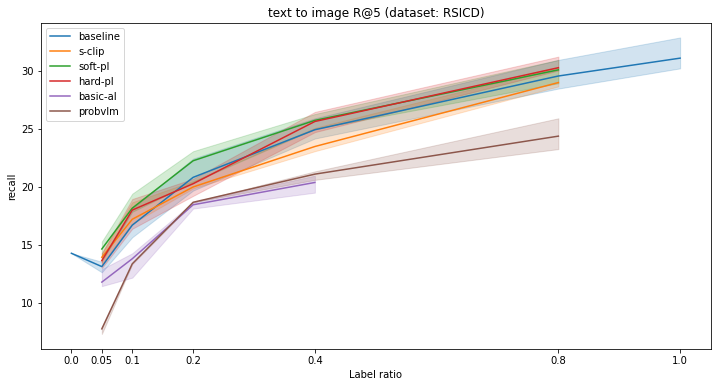

baseline text_to_image_R@5 UCM


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                               
233        0.0  64      0   False  0.00005  text_to_image_R@5   base     NaN   
8368      25.0  64     25   False  0.00005  text_to_image_R@5   base     NaN   
8369      25.0  64     25   False  0.00005  text_to_image_R@5   base     NaN   
8370      25.0  64     25   False  0.00005  text_to_image_R@5   base     NaN   
8371      25.0  64     25   False  0.00005  text_to_image_R@5   base     NaN   
8372      25.0  64     25   False  0.00005  text_to_image_R@5   base     NaN   
8373      25.0  64     25   False  0.00005  text_to_image_R@5   base     NaN   

     dataset ratio    PL   value                  \
                            mean       std count   
233      UCM  0.00  None  31.430  0.000000     2   
8368     UCM  0.05  None  35.142  3.341118     5   
8369     UCM  0.10  None  38.096  1.814657     5   
8370     UCM  0.20  None  48.666  1.033697     5   
8371     UCM  0.40  None  50.666  1.735578     5   
8372     UCM  0.80  None  55.334  1.824179     5   
8373     UCM  1.00  None  59.714  2.558062     5   

                                                         
                                      all    min    max  
233                        [31.43, 31.43]  31.43  31.43  
8368   [37.14, 36.19, 39.05, 31.9, 31.43]  31.43  39.05  
8369   [35.71, 40.0, 39.05, 36.67, 39.05]  35.71  40.00  
8370   [50.0, 48.57, 47.14, 49.05, 48.57]  47.14  50.00  
8371   [53.33, 50.0, 48.57, 50.95, 50.48]  48.57  53.33  
8372  [54.29, 54.29, 54.76, 58.57, 54.76]  54.29  58.57  
8373  [58.57, 61.43, 55.71, 61.43, 61.43]  55.71  61.43

s-clip text_to_image_R@5 UCM


AL.epochs   bs epochs ProbVLM       lr             metric method  \
                                                                         
12257      25.0  128     25   False  0.00005  text_to_image_R@5   ours   
12258      25.0  128     25   False  0.00005  text_to_image_R@5   ours   
12259      25.0  128     25   False  0.00005  text_to_image_R@5   ours   
12260      25.0  128     25   False  0.00005  text_to_image_R@5   ours   
12261      25.0  128     25   False  0.00005  text_to_image_R@5   ours   

      AL.iter dataset ratio        PL   value                  \
                                         mean       std count   
12257     NaN     UCM  0.05  ot.image  36.096  1.829393     5   
12258     NaN     UCM  0.10  ot.image  43.140  0.424853     5   
12259     NaN     UCM  0.20  ot.image  52.950  0.849706     5   
12260     NaN     UCM  0.40  ot.image  51.900  0.000000     5   
12261     NaN     UCM  0.80  ot.image  58.854  1.489221     5   

                                                          
                                       all    min    max  
12257    [34.76, 38.1, 34.76, 34.76, 38.1]  34.76  38.10  
12258  [43.33, 42.38, 43.33, 43.33, 43.33]  42.38  43.33  
12259  [53.33, 51.43, 53.33, 53.33, 53.33]  51.43  53.33  
12260       [51.9, 51.9, 51.9, 51.9, 51.9]  51.90  51.90  
12261  [59.52, 56.19, 59.52, 59.52, 59.52]  56.19  59.52

soft-pl text_to_image_R@5 UCM


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                               
9137      30.0  64     30   False  0.00005  text_to_image_R@5   ours     NaN   
9138      30.0  64     30   False  0.00005  text_to_image_R@5   ours     NaN   
9139      30.0  64     30   False  0.00005  text_to_image_R@5   ours     NaN   
9140      30.0  64     30   False  0.00005  text_to_image_R@5   ours     NaN   
9141      30.0  64     30   False  0.00005  text_to_image_R@5   ours     NaN   

     dataset ratio         PL   value                  \
                                 mean       std count   
9137     UCM  0.05  soft.text  38.192  3.292107     5   
9138     UCM  0.10  soft.text  42.476  1.362289     5   
9139     UCM  0.20  soft.text  46.474  0.926974     5   
9140     UCM  0.40  soft.text  52.188  1.192841     5   
9141     UCM  0.80  soft.text  57.618  1.431667     5   

                                                         
                                      all    min    max  
9137  [40.48, 33.33, 36.19, 40.48, 40.48]  33.33  40.48  
9138  [42.38, 44.76, 41.43, 41.43, 42.38]  41.43  44.76  
9139  [47.14, 45.71, 45.24, 47.14, 47.14]  45.24  47.14  
9140    [53.33, 50.48, 51.9, 51.9, 53.33]  50.48  53.33  
9141  [57.14, 59.05, 55.71, 59.05, 57.14]  55.71  59.05

hard-pl text_to_image_R@5 UCM


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                               
8394      25.0  64     25   False  0.00005  text_to_image_R@5   ours     NaN   
8396      25.0  64     25   False  0.00005  text_to_image_R@5   ours     NaN   
8398      25.0  64     25   False  0.00005  text_to_image_R@5   ours     NaN   
8400      25.0  64     25   False  0.00005  text_to_image_R@5   ours     NaN   
8402      25.0  64     25   False  0.00005  text_to_image_R@5   ours     NaN   

     dataset ratio         PL   value                  \
                                 mean       std count   
8394     UCM  0.05  hard.text  35.430  3.755210     5   
8396     UCM  0.10  hard.text  43.906  3.390403     5   
8398     UCM  0.20  hard.text  48.476  3.202246     5   
8400     UCM  0.40  hard.text  53.998  3.096784     5   
8402     UCM  0.80  hard.text  59.808  2.553590     5   

                                                         
                                      all    min    max  
8394   [34.29, 35.24, 32.86, 41.9, 32.86]  32.86  41.90  
8396  [41.43, 47.62, 41.43, 47.62, 41.43]  41.43  47.62  
8398  [46.19, 50.95, 52.86, 46.19, 46.19]  46.19  52.86  
8400   [58.57, 53.33, 50.0, 54.76, 53.33]  50.00  58.57  
8402  [60.95, 55.24, 60.95, 60.95, 60.95]  55.24  60.95

basic-al text_to_image_R@5 UCM


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                              
182      10.0  64     20   False  0.00005  text_to_image_R@5   base     2.0   
185      10.0  64     20   False  0.00005  text_to_image_R@5   base     5.0   
188      10.0  64     20   False  0.00005  text_to_image_R@5   base    10.0   
191      10.0  64     20   False  0.00005  text_to_image_R@5   base    20.0   

    dataset ratio    PL   value                  \
                           mean       std count   
182     UCM  0.05  None  32.762  0.854178     5   
185     UCM  0.10  None  41.620  0.424853     5   
188     UCM  0.20  None  46.856  3.647832     5   
191     UCM  0.40  None  50.572  3.132973     5   

                                                        
                                     all    min    max  
182  [32.38, 32.38, 34.29, 32.38, 32.38]  32.38  34.29  
185  [41.43, 41.43, 41.43, 42.38, 41.43]  41.43  42.38  
188  [49.52, 49.52, 42.86, 42.86, 49.52]  42.86  49.52  
191  [52.86, 52.86, 47.14, 47.14, 52.86]  47.14  52.86

probvlm text_to_image_R@5 UCM


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                             
77      10.0  32     25    True  0.00005  text_to_image_R@5   base     2.0   
80      10.0  32     25    True  0.00005  text_to_image_R@5   base     5.0   
83      10.0  32     25    True  0.00005  text_to_image_R@5   base    10.0   
86      10.0  32     25    True  0.00005  text_to_image_R@5   base    20.0   
89      10.0  32     25    True  0.00005  text_to_image_R@5   base    40.0   

   dataset ratio    PL   value                  \
                          mean       std count   
77     UCM  0.05  None  29.242  2.768252     5   
80     UCM  0.10  None  40.000  0.000000     5   
83     UCM  0.20  None  47.620  0.000000     5   
86     UCM  0.40  None  45.528  2.768252     5   
89     UCM  0.80  None  48.000  2.552156     5   

                                                       
                                    all    min    max  
77  [30.48, 24.29, 30.48, 30.48, 30.48]  24.29  30.48  
80       [40.0, 40.0, 40.0, 40.0, 40.0]  40.00  40.00  
83  [47.62, 47.62, 47.62, 47.62, 47.62]  47.62  47.62  
86  [44.29, 44.29, 44.29, 44.29, 50.48]  44.29  50.48  
89  [48.57, 45.24, 45.71, 49.05, 51.43]  45.24  51.43

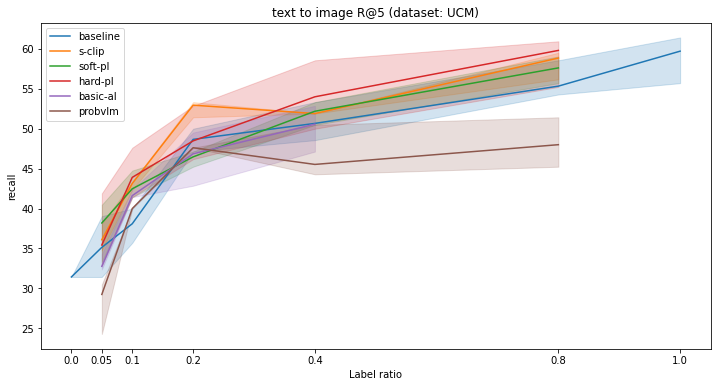

baseline text_to_image_R@5 Sydney


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                               
232        0.0  64      0   False  0.00005  text_to_image_R@5   base     NaN   
8362      25.0  64     25   False  0.00005  text_to_image_R@5   base     NaN   
8363      25.0  64     25   False  0.00005  text_to_image_R@5   base     NaN   
8364      25.0  64     25   False  0.00005  text_to_image_R@5   base     NaN   
8365      25.0  64     25   False  0.00005  text_to_image_R@5   base     NaN   
8366      25.0  64     25   False  0.00005  text_to_image_R@5   base     NaN   
8367      25.0  64     25   False  0.00005  text_to_image_R@5   base     NaN   

     dataset ratio    PL   value                  \
                            mean       std count   
232   Sydney  0.00  None  10.660  0.000000     2   
8362  Sydney  0.05  None  10.746  0.677370     5   
8363  Sydney  0.10  None  14.406  1.293940     5   
8364  Sydney  0.20  None  18.350  2.141775     5   
8365  Sydney  0.40  None  27.044  1.087764     5   
8366  Sydney  0.80  None  36.578  1.041091     5   
8367  Sydney  1.00  None  37.666  0.438668     5   

                                                         
                                      all    min    max  
232                        [10.66, 10.66]  10.66  10.66  
8362   [9.86, 11.47, 11.27, 10.87, 10.26]   9.86  11.47  
8363   [13.48, 16.1, 13.28, 13.68, 15.49]  13.28  16.10  
8364   [15.49, 19.52, 19.52, 16.7, 20.52]  15.49  20.52  
8365  [26.36, 28.57, 25.96, 27.77, 26.56]  25.96  28.57  
8366  [35.81, 37.63, 36.82, 37.42, 35.21]  35.21  37.63  
8367  [37.42, 38.03, 37.02, 38.03, 37.83]  37.02  38.03

s-clip text_to_image_R@5 Sydney


AL.epochs   bs epochs ProbVLM       lr             metric method  \
                                                                         
12252      25.0  128     25   False  0.00005  text_to_image_R@5   ours   
12253      25.0  128     25   False  0.00005  text_to_image_R@5   ours   
12254      25.0  128     25   False  0.00005  text_to_image_R@5   ours   
12255      25.0  128     25   False  0.00005  text_to_image_R@5   ours   
12256      25.0  128     25   False  0.00005  text_to_image_R@5   ours   

      AL.iter dataset ratio        PL   value                  \
                                         mean       std count   
12252     NaN  Sydney  0.05  ot.image   9.742  1.077785     5   
12253     NaN  Sydney  0.10  ot.image  14.568  0.720014     5   
12254     NaN  Sydney  0.20  ot.image  17.140  0.357771     5   
12255     NaN  Sydney  0.40  ot.image  22.014  1.529470     5   
12256     NaN  Sydney  0.80  ot.image  31.710  0.178885     5   

                                                          
                                       all    min    max  
12252      [9.26, 9.26, 9.26, 9.26, 11.67]   9.26  11.67  
12253  [14.89, 13.28, 14.89, 14.89, 14.89]  13.28  14.89  
12254       [17.3, 16.5, 17.3, 17.3, 17.3]  16.50  17.30  
12255  [21.33, 24.75, 21.33, 21.33, 21.33]  21.33  24.75  
12256  [31.79, 31.39, 31.79, 31.79, 31.79]  31.39  31.79

soft-pl text_to_image_R@5 Sydney


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                               
9132      30.0  64     30   False  0.00005  text_to_image_R@5   ours     NaN   
9133      30.0  64     30   False  0.00005  text_to_image_R@5   ours     NaN   
9134      30.0  64     30   False  0.00005  text_to_image_R@5   ours     NaN   
9135      30.0  64     30   False  0.00005  text_to_image_R@5   ours     NaN   
9136      30.0  64     30   False  0.00005  text_to_image_R@5   ours     NaN   

     dataset ratio         PL   value                  \
                                 mean       std count   
9132  Sydney  0.05  soft.text  11.146  2.197494     5   
9133  Sydney  0.10  soft.text  12.714  1.453850     5   
9134  Sydney  0.20  soft.text  17.382  0.719458     5   
9135  Sydney  0.40  soft.text  20.806  1.218536     5   
9136  Sydney  0.80  soft.text  27.848  0.442063     5   

                                                         
                                      all    min    max  
9132    [13.48, 10.46, 9.26, 13.48, 9.05]   9.05  13.48  
9133  [12.27, 15.29, 11.87, 11.87, 12.27]  11.87  15.29  
9134      [17.3, 16.5, 18.51, 17.3, 17.3]  16.50  18.51  
9135  [19.52, 21.13, 21.93, 21.93, 19.52]  19.52  21.93  
9136  [27.97, 28.37, 27.16, 27.77, 27.97]  27.16  28.37

hard-pl text_to_image_R@5 Sydney


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                               
8384      25.0  64     25   False  0.00005  text_to_image_R@5   ours     NaN   
8386      25.0  64     25   False  0.00005  text_to_image_R@5   ours     NaN   
8388      25.0  64     25   False  0.00005  text_to_image_R@5   ours     NaN   
8390      25.0  64     25   False  0.00005  text_to_image_R@5   ours     NaN   
8392      25.0  64     25   False  0.00005  text_to_image_R@5   ours     NaN   

     dataset ratio         PL   value                  \
                                 mean       std count   
8384  Sydney  0.05  hard.text   9.656  0.752350     5   
8386  Sydney  0.10  hard.text  12.876  0.493994     5   
8388  Sydney  0.20  hard.text  16.016  0.848664     5   
8390  Sydney  0.40  hard.text  21.328  1.865508     5   
8392  Sydney  0.80  hard.text  26.200  0.089443     5   

                                                         
                                      all    min    max  
8384     [9.26, 10.66, 9.05, 10.26, 9.05]   9.05  10.66  
8386  [13.68, 12.88, 12.47, 12.88, 12.47]  12.47  13.68  
8388     [14.69, 16.3, 15.69, 16.7, 16.7]  14.69  16.70  
8390  [19.72, 23.34, 19.72, 20.52, 23.34]  19.72  23.34  
8392  [26.16, 26.36, 26.16, 26.16, 26.16]  26.16  26.36

basic-al text_to_image_R@5 Sydney


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                              
181      10.0  64     20   False  0.00005  text_to_image_R@5   base     2.0   
184      10.0  64     20   False  0.00005  text_to_image_R@5   base     5.0   
187      10.0  64     20   False  0.00005  text_to_image_R@5   base    10.0   
190      10.0  64     20   False  0.00005  text_to_image_R@5   base    20.0   

    dataset ratio    PL   value                  \
                           mean       std count   
181  Sydney  0.05  None  10.460  0.244949     5   
184  Sydney  0.10  None  13.202  0.720014     5   
187  Sydney  0.20  None  16.016  0.662744     5   
190  Sydney  0.40  None  25.996  0.772289     5   

                                                        
                                     all    min    max  
181  [10.46, 10.66, 10.06, 10.66, 10.46]  10.06  10.66  
184  [12.88, 12.88, 12.88, 14.49, 12.88]  12.88  14.49  
187     [16.5, 16.5, 15.29, 15.29, 16.5]  15.29  16.50  
190  [26.56, 26.56, 25.15, 25.15, 26.56]  25.15  26.56

probvlm text_to_image_R@5 Sydney


AL.epochs  bs epochs ProbVLM       lr             metric method AL.iter  \
                                                                             
76      10.0  32     25    True  0.00005  text_to_image_R@5   base     2.0   
79      10.0  32     25    True  0.00005  text_to_image_R@5   base     5.0   
82      10.0  32     25    True  0.00005  text_to_image_R@5   base    10.0   
85      10.0  32     25    True  0.00005  text_to_image_R@5   base    20.0   
88      10.0  32     25    True  0.00005  text_to_image_R@5   base    40.0   

   dataset ratio    PL   value                      \
                          mean           std count   
76  Sydney  0.05  None   8.810  8.944272e-02     5   
79  Sydney  0.10  None  10.460  0.000000e+00     5   
82  Sydney  0.20  None  14.690  1.986027e-15     5   
85  Sydney  0.40  None  15.978  7.186237e-01     5   
88  Sydney  0.80  None  20.846  2.213895e+00     5   

                                                       
                                    all    min    max  
76       [8.85, 8.65, 8.85, 8.85, 8.85]   8.65   8.85  
79  [10.46, 10.46, 10.46, 10.46, 10.46]  10.46  10.46  
82  [14.69, 14.69, 14.69, 14.69, 14.69]  14.69  14.69  
85      [15.9, 15.9, 15.9, 15.09, 17.1]  15.09  17.10  
88  [21.13, 20.12, 17.51, 22.13, 23.34]  17.51  23.34

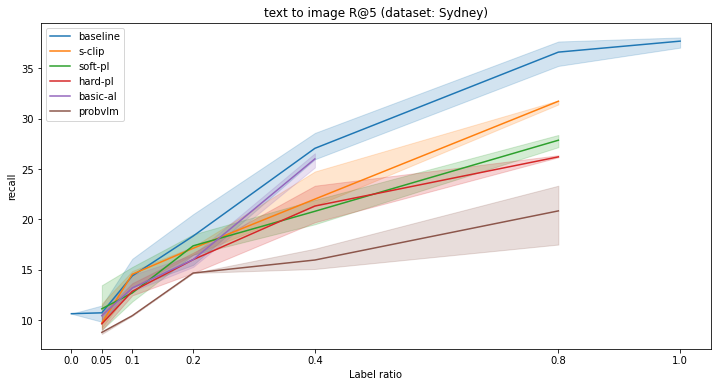

In [21]:
metrics = ['image_to_text_R@5', 'text_to_image_R@5']
datasets = ['RSICD', 'UCM', 'Sydney']
for metric in metrics:
    for dataset in datasets:
        only_scores = plot_model_comparison(results_dict, metric, dataset)
#         print(only_scores)
#         for model in only_scores:
#             scores_grouped = only_scores[model]
#             for group_of_scores in scores_grouped:
#                 print(group_of_scores)
#                 plt.scatter([0] * len(group_of_scores), sorted(group_of_scores))
#                 plt.title(f"{model} {dataset} {metric}")
#                 plt.show()

In [ ]:
metric = 'zeroshot-val-top1'
datasets = ["RSICD-CLS", "UCM-CLS", "WHU-RS19", "RSSCN7", "AID", "RESISC45"]
for dataset in datasets:
    print(dataset, metric)
    plot_model_comparison(results_dict, metric, dataset)

In [ ]:
metric = 'text_to_image_R@5'
datasets = ['RSICD', 'UCM', 'Sydney']
for dataset in datasets:
    plot_model_comparison(results_dict, metric, dataset)